# Pytorch - Image Classifier (Faces)

## Pytorch Dataset

In [1]:
#Import packages and models
from PIL import Image
from glob import glob
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
#Declare CelebsDataSet class
class CelebsDataSet(Dataset):
    def __init__(self,data_dir,transform=None):
        self.data=ImageFolder(data_dir,transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
    @property
    def classes(self):
        return self.data.classes

In [3]:
data_dir='../data/Face recognition/Faces' #dataset
noc= 31 #Number of classes
original_dataset=CelebsDataSet(data_dir)

In [4]:
len(original_dataset)

1483

0


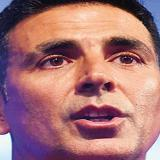

In [5]:
image,label=original_dataset[5]
print(label)
image

In [6]:
#Get a dictionary associating target values with folder names
target_to_class={v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Akshay Kumar', 1: 'Alexandra Daddario', 2: 'Alia Bhatt', 3: 'Amitabh Bachchan', 4: 'Andy Samberg', 5: 'Anushka Sharma', 6: 'Billie Eilish', 7: 'Brad Pitt', 8: 'Camila Cabello', 9: 'Charlize Theron', 10: 'Claire Holt', 11: 'Courtney Cox', 12: 'Dwayne Johnson', 13: 'Elizabeth Olsen', 14: 'Ellen Degeneres', 15: 'Henry Cavill', 16: 'Hrithik Roshan', 17: 'Hugh Jackman', 18: 'Jessica Alba', 19: 'Kashyap', 20: 'Lisa Kudrow', 21: 'Margot Robbie', 22: 'Marmik', 23: 'Natalie Portman', 24: 'Priyanka Chopra', 25: 'Robert Downey Jr', 26: 'Roger Federer', 27: 'Tom Cruise', 28: 'Vijay Deverakonda', 29: 'Virat Kohli', 30: 'Zac Efron'}


In [7]:
#Making sure that images are always 160x160
transform=transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
])

In [8]:
#Train-test spliting
original_dataset=CelebsDataSet(data_dir,transform)
train_size = int(0.6 * len(original_dataset))
valid_size = int(0.2 * len(original_dataset)) 
test_size = len(original_dataset) - (train_size+valid_size)
train_size += len(original_dataset) - (train_size + valid_size + test_size)

dataset, valid_dataset, test_dataset = torch.utils.data.random_split(original_dataset, [train_size, valid_size, test_size])

#Running it for a random image
image,label=dataset[100]
print(image)
print(image.shape)

tensor([[[0.6275, 0.6667, 0.2706,  ..., 0.2118, 0.1451, 0.2667],
         [0.6392, 0.5098, 0.3529,  ..., 0.6039, 0.5412, 0.6588],
         [0.5569, 0.3490, 0.3137,  ..., 0.7843, 0.5725, 0.4706],
         ...,
         [0.2863, 0.2863, 0.2863,  ..., 0.9608, 0.9569, 0.9569],
         [0.2824, 0.2824, 0.2824,  ..., 0.9608, 0.9608, 0.9608],
         [0.2824, 0.2824, 0.2824,  ..., 0.9647, 0.9608, 0.9608]],

        [[0.5569, 0.5961, 0.1961,  ..., 0.1569, 0.0980, 0.2196],
         [0.5686, 0.4392, 0.2784,  ..., 0.5490, 0.4863, 0.6118],
         [0.4863, 0.2784, 0.2392,  ..., 0.7294, 0.5176, 0.4157],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.9608, 0.9569, 0.9569],
         [0.3294, 0.3294, 0.3294,  ..., 0.9608, 0.9608, 0.9608],
         [0.3294, 0.3294, 0.3294,  ..., 0.9647, 0.9608, 0.9608]],

        [[0.4706, 0.5098, 0.1294,  ..., 0.1529, 0.0980, 0.2196],
         [0.4824, 0.3608, 0.2118,  ..., 0.5451, 0.4863, 0.6118],
         [0.4078, 0.2000, 0.1725,  ..., 0.7255, 0.5137, 0.

In [9]:
#iterate over dataset
for images,labels in dataset:
    break

In [10]:
#iterate over dataset using dataloader after batching for faster training
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)
for images,labels in dataloader:
    break
images.shape,labels.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32]))

## Pytorch Model

In [11]:
class SimpleImageClassifier(nn.Module):
    def __init__(self,num_classes=noc):
        super(SimpleImageClassifier,self).__init__()
        #Here we define all the parts of the model
        self.base_model=timm.create_model('efficientnet_b0',pretrained=True)
        self.features=nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size=self.base_model.classifier.in_features
        #Make a classifier to resize to our number of classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self,x):
        #Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [12]:
model=SimpleImageClassifier(num_classes=noc)
print(str(model)[:500])

SimpleImageClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=F


In [13]:
example_out=model(images)
example_out.shape

torch.Size([32, 31])

## Training Loop

In [14]:
#Loss function
criterion=nn.CrossEntropyLoss()
#Optimizer
optimizer=optim.Adam(model.parameters(),lr=0.001)
print(criterion)
print('\n')
print(optimizer)

CrossEntropyLoss()


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [15]:
#ensuring that the shapes match
criterion(example_out,labels)
print(example_out.shape,labels.shape)

torch.Size([32, 31]) torch.Size([32])


### Engineering the data

In [16]:
transform=transforms.Compose(
    [
        transforms.Resize((160,160)),
        transforms.ToTensor(),
    ]
)

#Create specific loader for these datasets
train_loader=DataLoader(dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=False)

### Checking whether GPU is available

In [17]:
#We define the device for the model to run on:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Training Starts

In [18]:
#one run through the entire dataset
num_epochs=2
train_losses,valid_losses,epochs=[],[],[]
model=SimpleImageClassifier(num_classes=noc)
model.to(device) #moving the model to the gpu
#Loss function
criterion=nn.CrossEntropyLoss()
#Optimizer
optimizer=optim.Adam(model.parameters(),lr=0.001)

for epoch in range(0,num_epochs):
    #Set the model to train
    model.train()
    running_loss=0.0
    for images,labels in tqdm(train_loader,desc='Training Loop'):
        images,labels=images.to(device),labels.to(device)  #moving the images and labels to the gpu
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*labels.size(0)
    train_loss=running_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    
    #Validation phase
    model.eval()
    running_loss=0.0    
    with torch.no_grad():
        for images,labels in tqdm(valid_loader,desc='Validation Loop'):
            images,labels=images.to(device),labels.to(device)  #moving the images and labels to the gpu
            outputs=model(images)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()*labels.size(0)
    valid_loss=running_loss/len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    epochs.append(epoch+1)
    #Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss}, Validation Loss: {valid_loss}")

Training Loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/2 - Training Loss: 2.384884610889465, Validation Loss: 1.612560459085413


Training Loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/2 - Training Loss: 0.5206782754816542, Validation Loss: 0.9591818419662682


### Visualize Losses

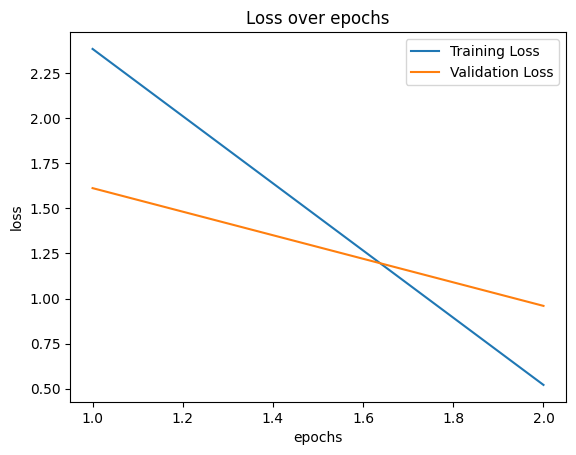

In [19]:
plt.plot(epochs,train_losses,label='Training Loss')
plt.plot(epochs,valid_losses,label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

## Bonus: Evaluate the results

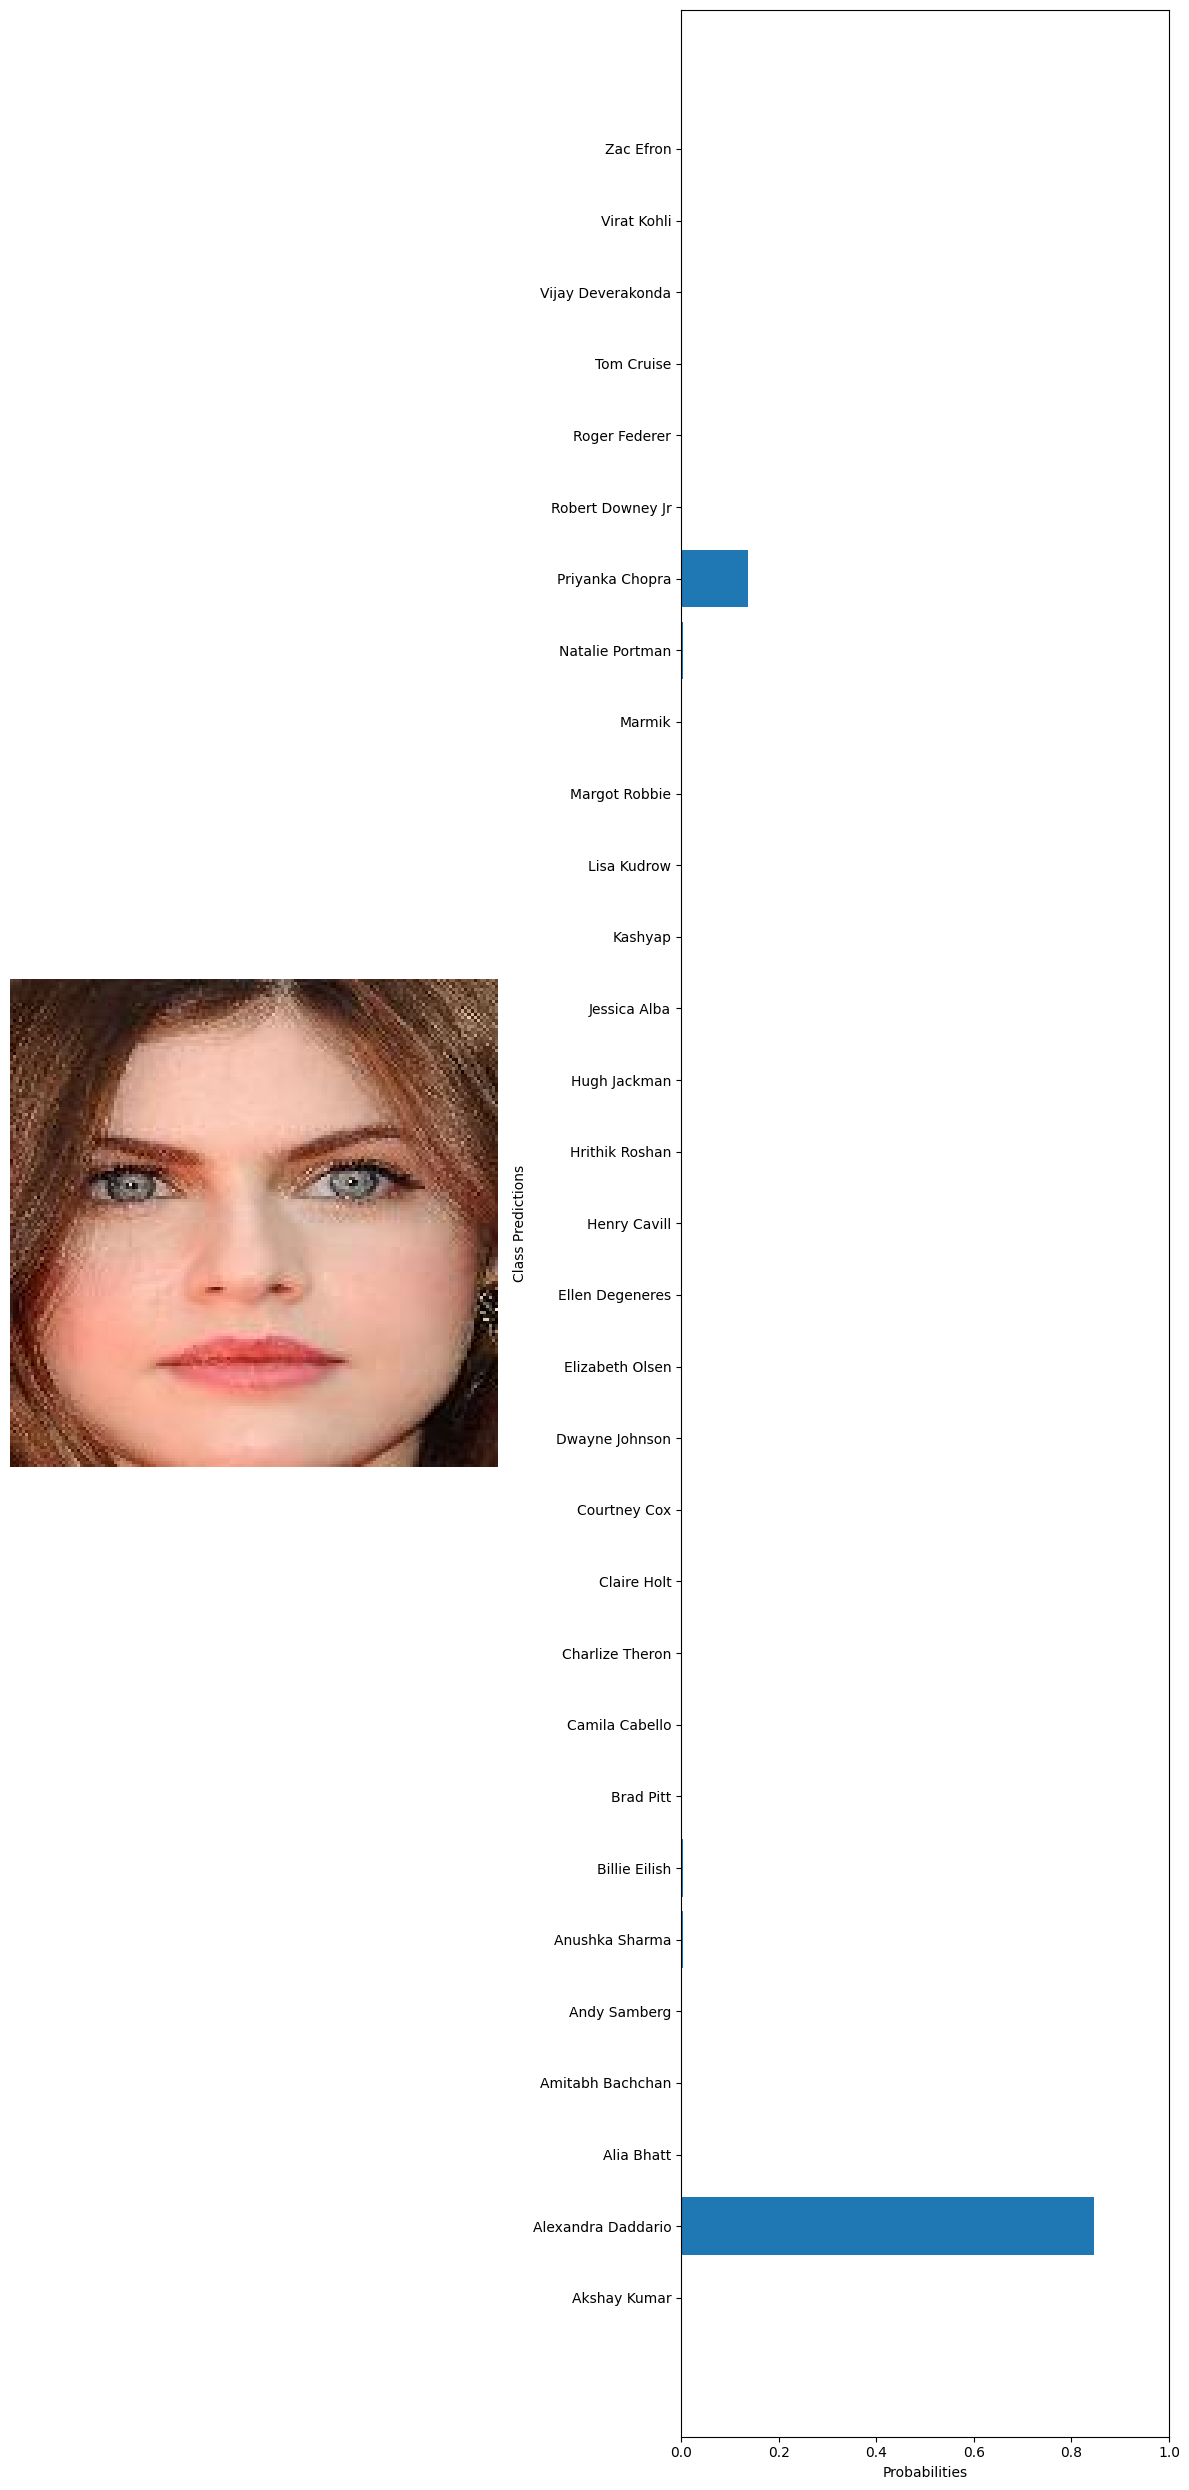

In [20]:
#Load and preprocess the image:
def preprocess_image(image_path,transform):
    image=Image.open(image_path).convert('RGB')
    return image,transform(image).unsqueeze(0)

#Predict using the model:
def predict(model, image_tensor,device):
    model.eval()
    with torch.no_grad():
        image_tensor=image_tensor.to(device)
        outputs=model(image_tensor)
        probabilities =torch.nn.functional.softmax(outputs,dim=1)
    return probabilities.cpu().numpy().flatten()

#Visualization
def visualize_predictions(original_image,probabilities,class_names):
    fig,axarr=plt.subplots(1,2,figsize=(12,25))
    #Display image
    axarr[0].imshow(original_image)
    axarr[0].axis('off')
    #Display predictions
    axarr[1].barh(class_names,probabilities)
    axarr[1].set_xlabel('Probabilities')
    axarr[1].set_ylabel('Class Predictions')
    axarr[1].set_xlim(0,1)
    
    plt.tight_layout()
    plt.show()
    
#Example usage
test_image='../data/Face recognition/Faces/Alexandra Daddario/Alexandra Daddario_13.jpg'
transform=transforms.Compose(
    [
        transforms.Resize((160,160)),
        transforms.ToTensor()
    ]
)

original_image,image_tensor=preprocess_image(test_image,transform)
probabilities=predict(model,image_tensor,device)

# Assuming the class names from model.classifier
class_names = dataset.dataset.classes
visualize_predictions(original_image,probabilities,class_names)

True label: Jessica Alba
Predicted label: Jessica Alba


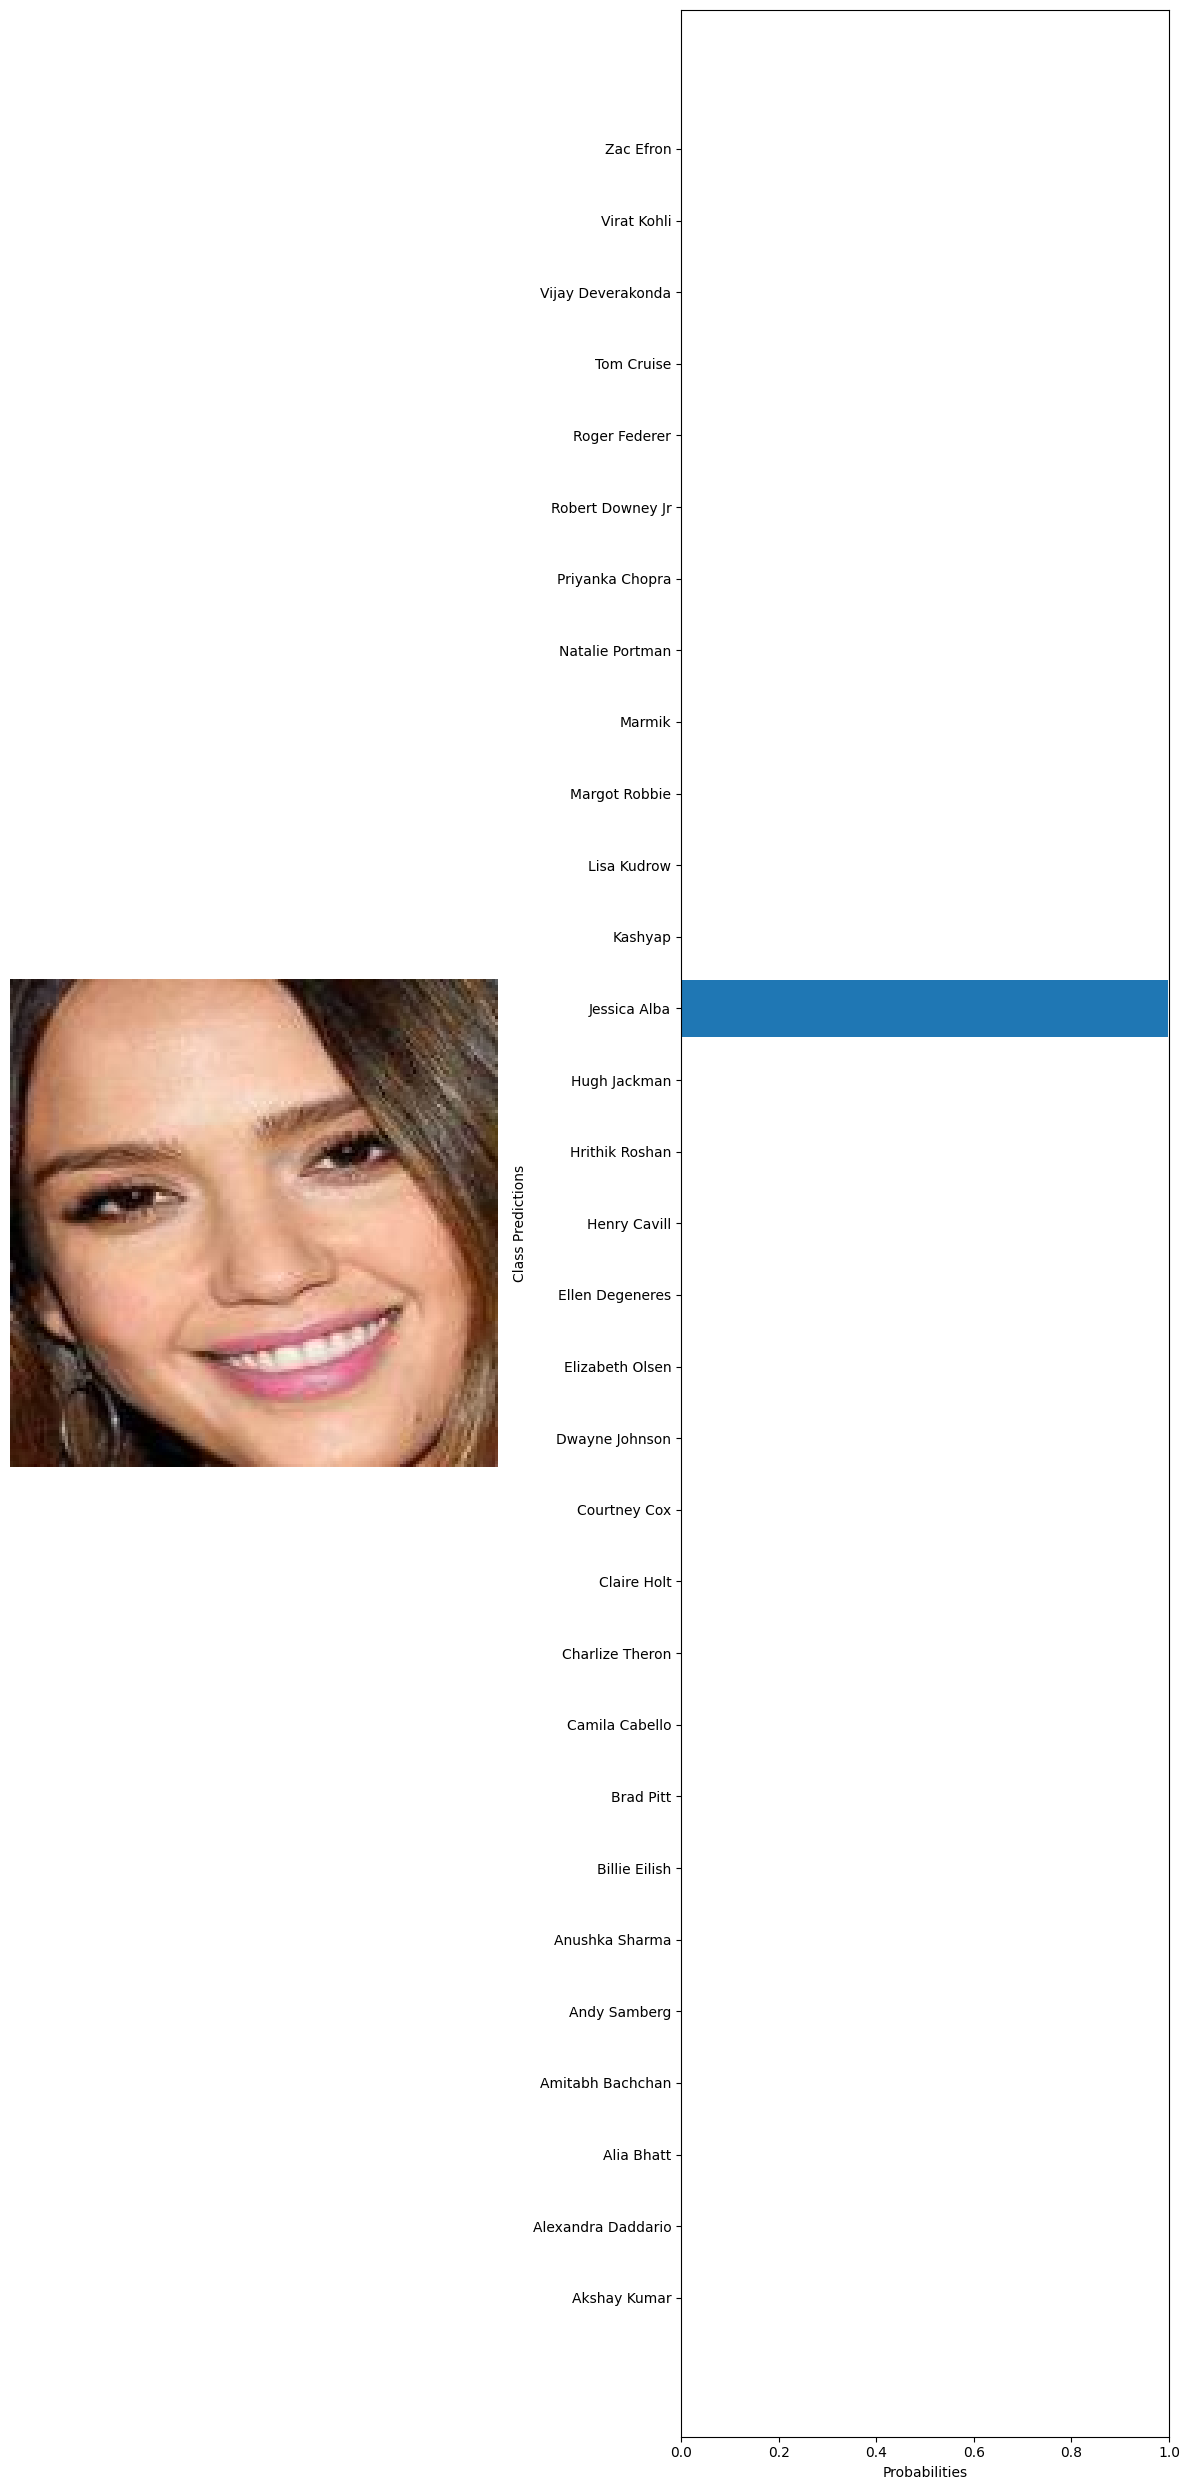

True label: Alia Bhatt
Predicted label: Alia Bhatt


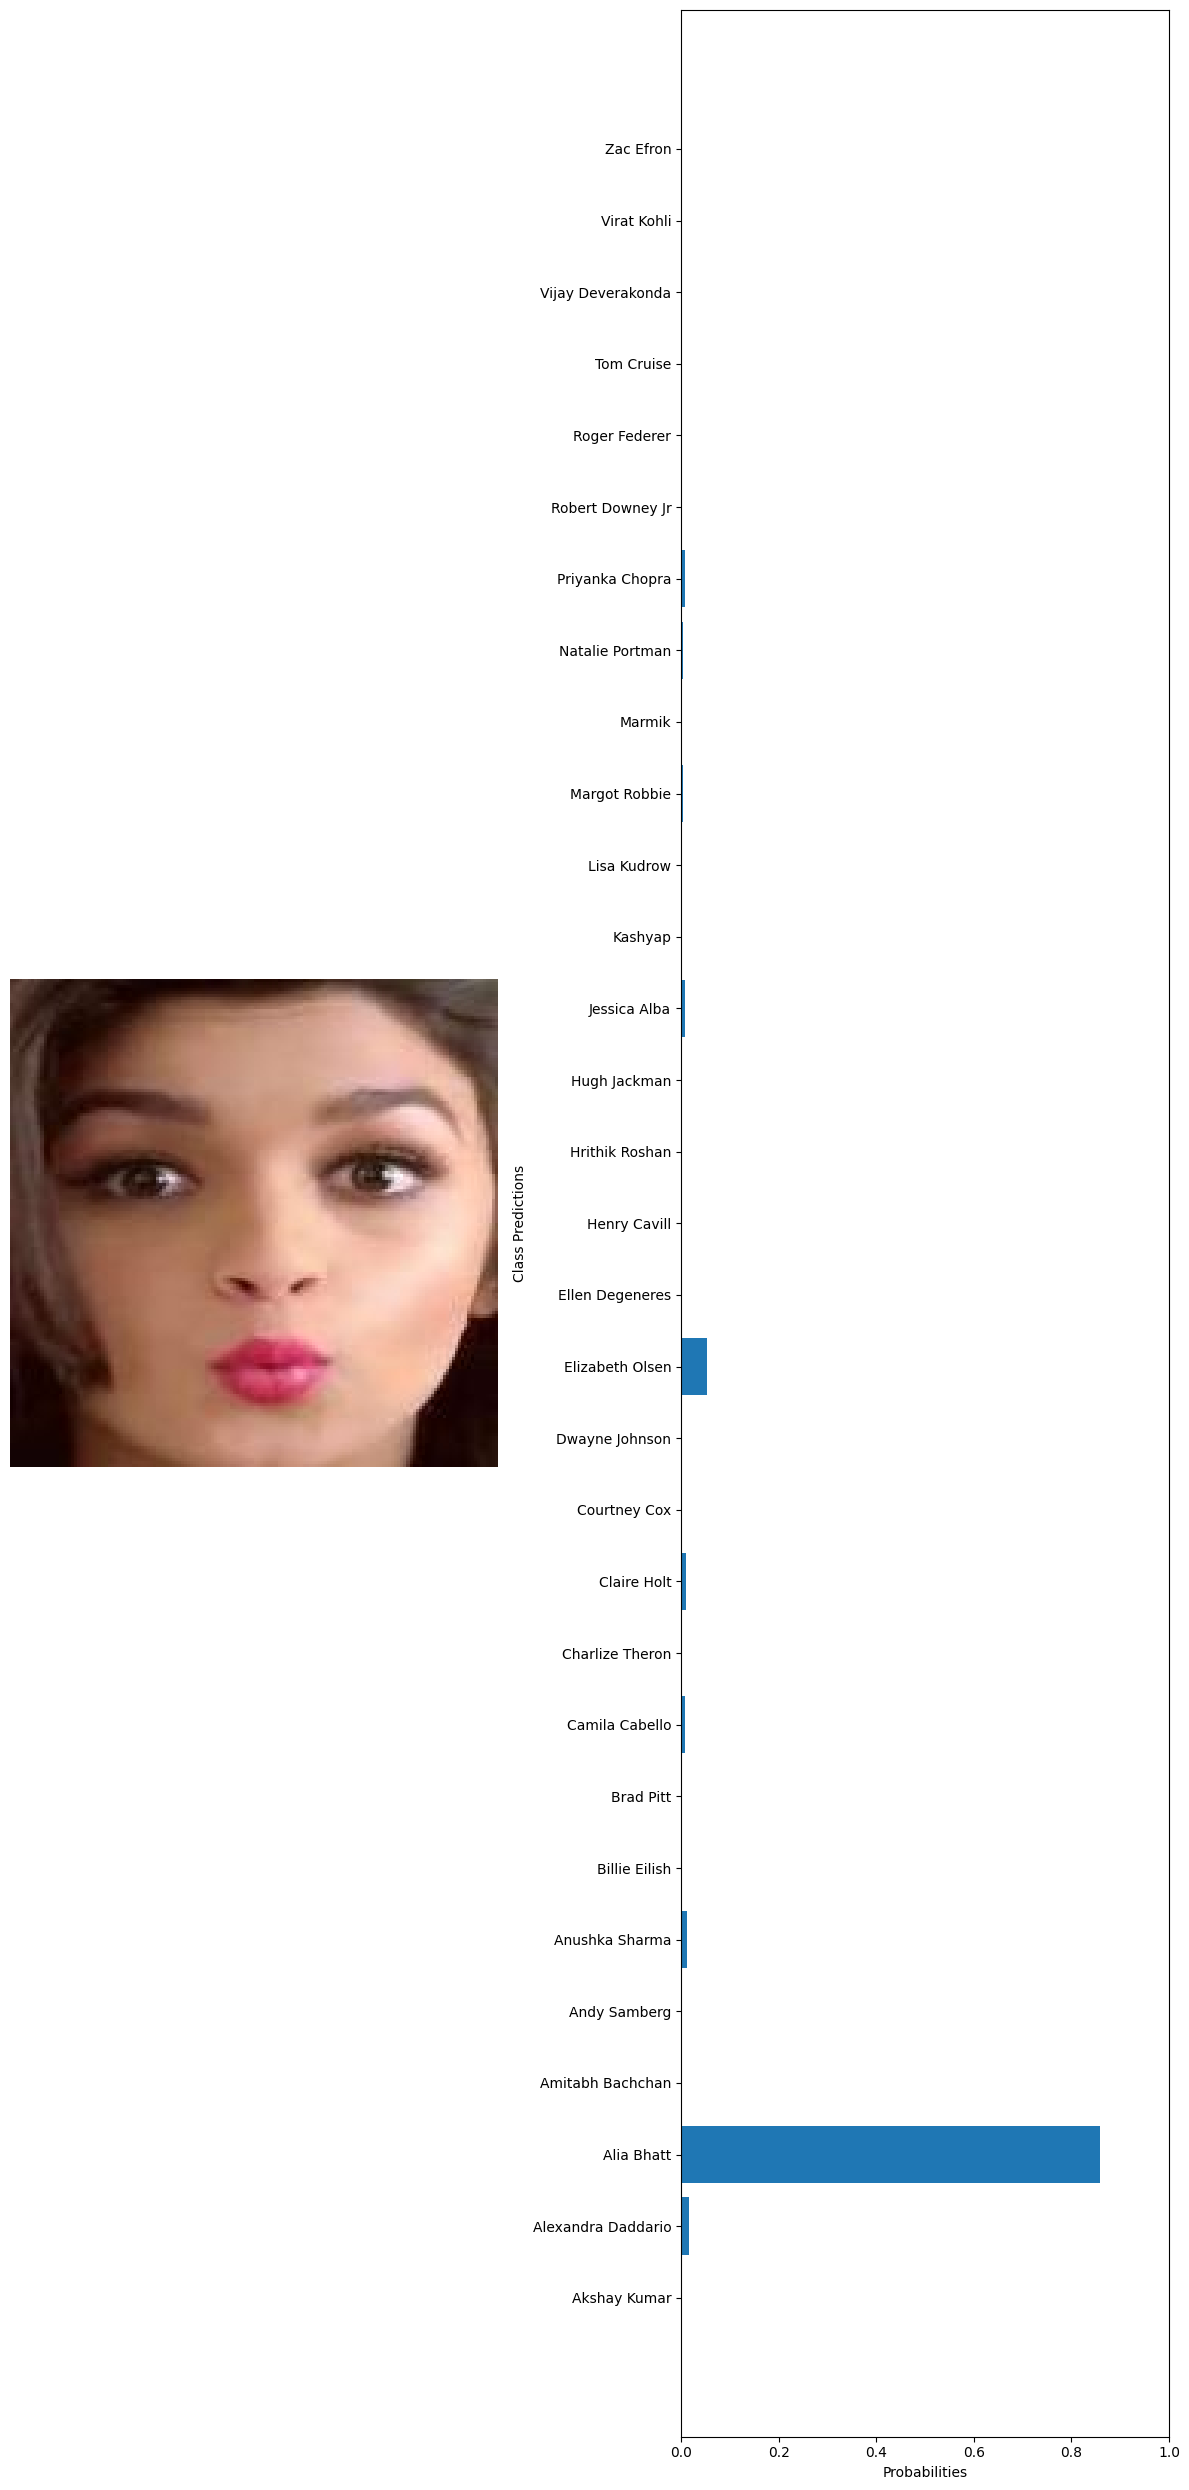

True label: Charlize Theron
Predicted label: Charlize Theron


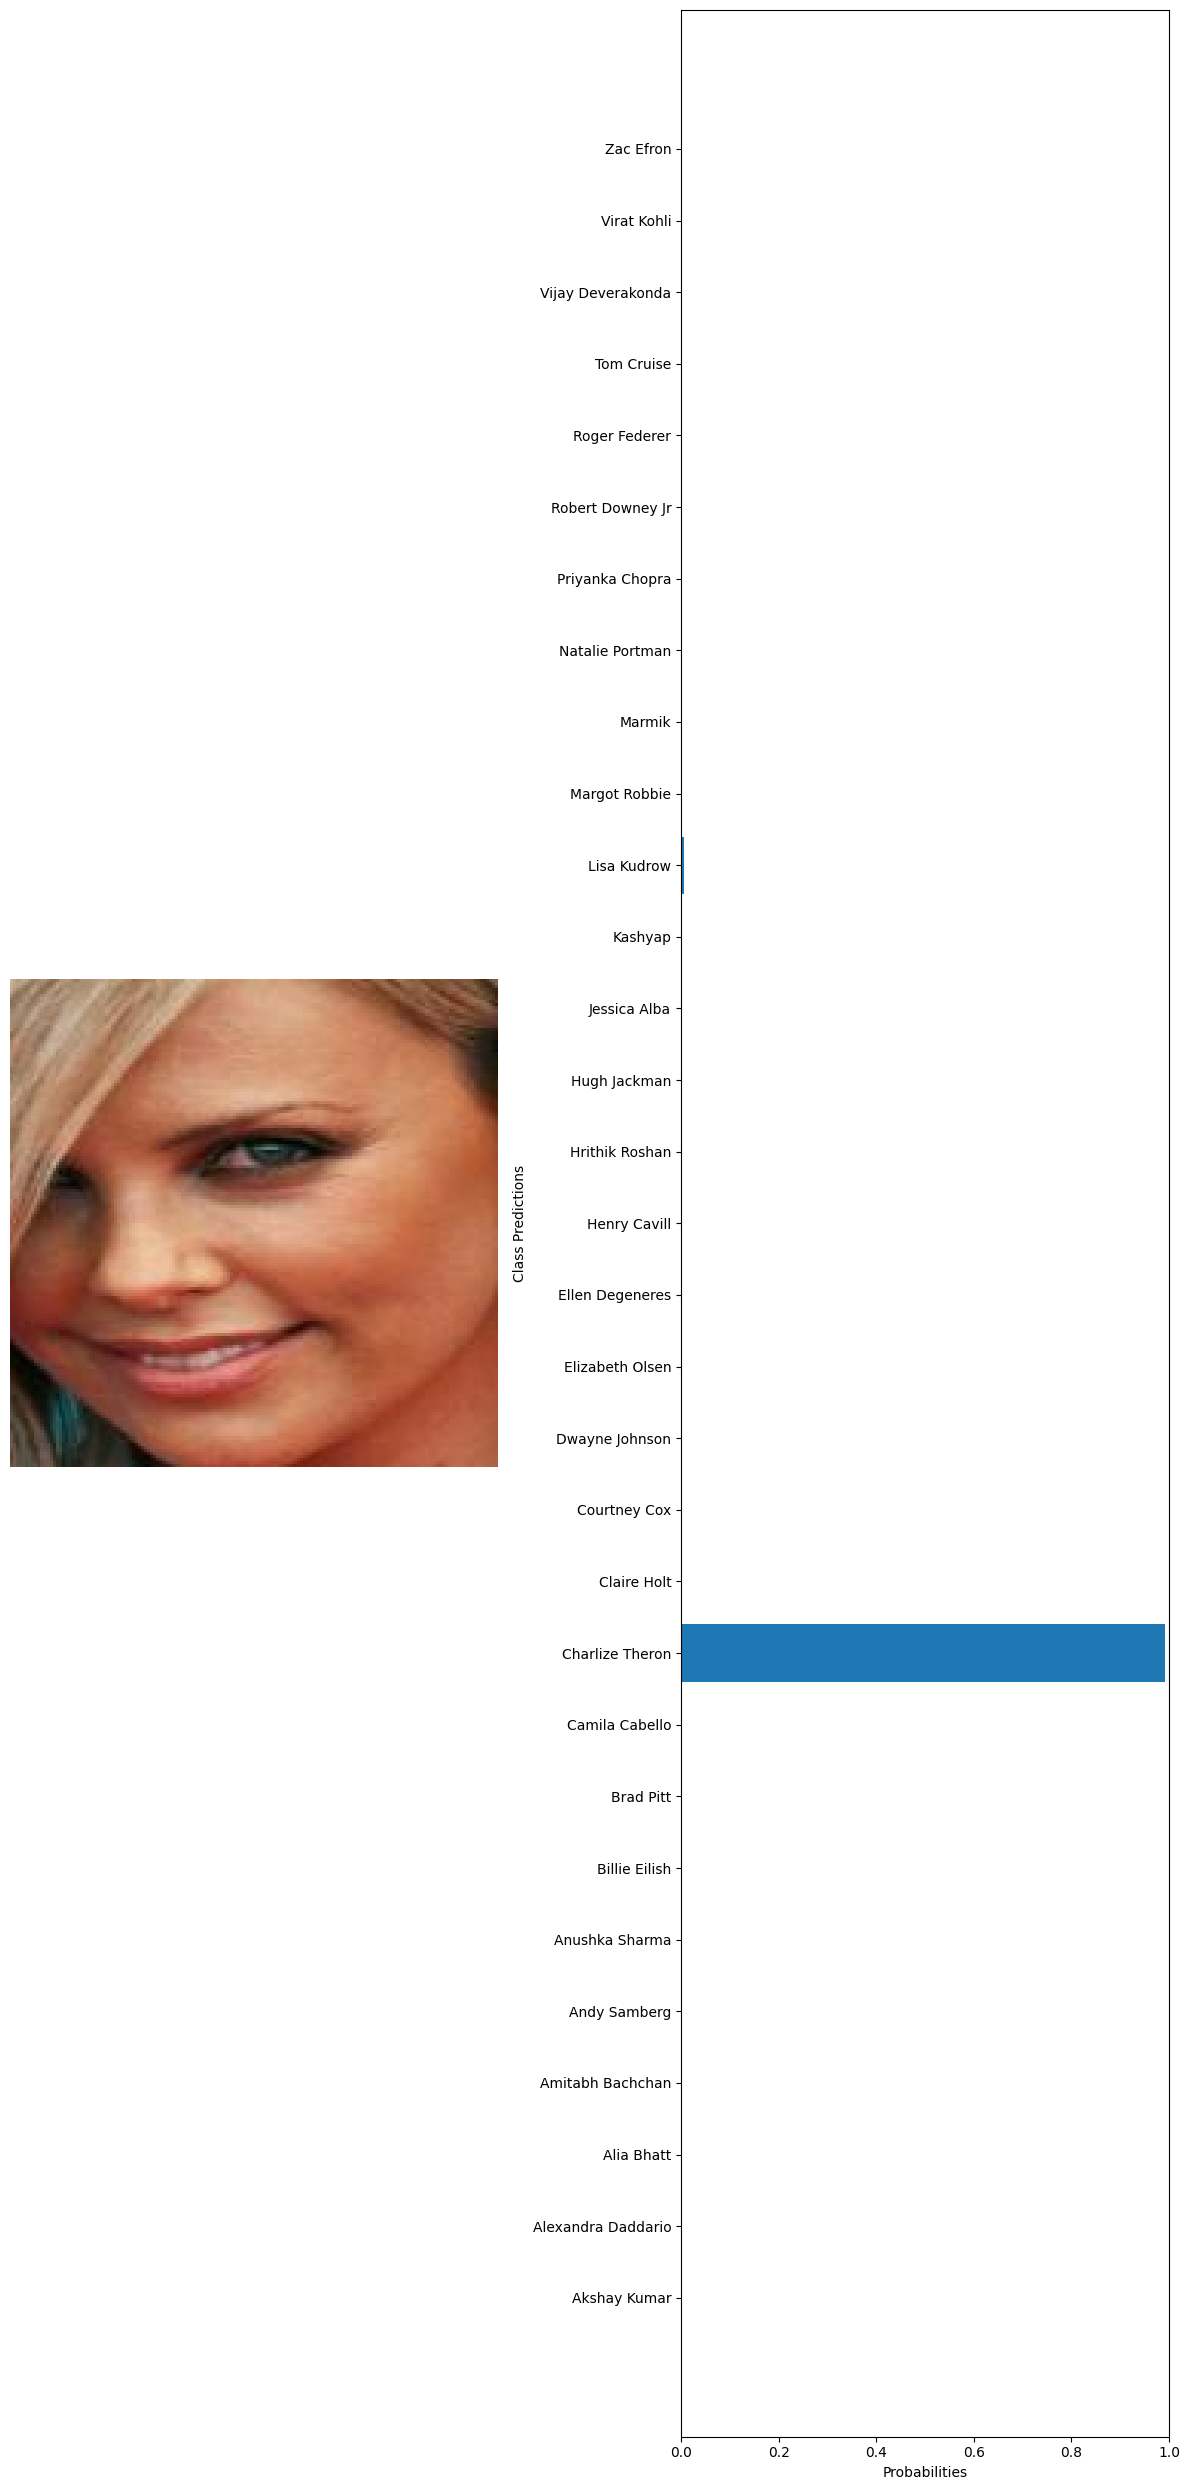

True label: Priyanka Chopra
Predicted label: Priyanka Chopra


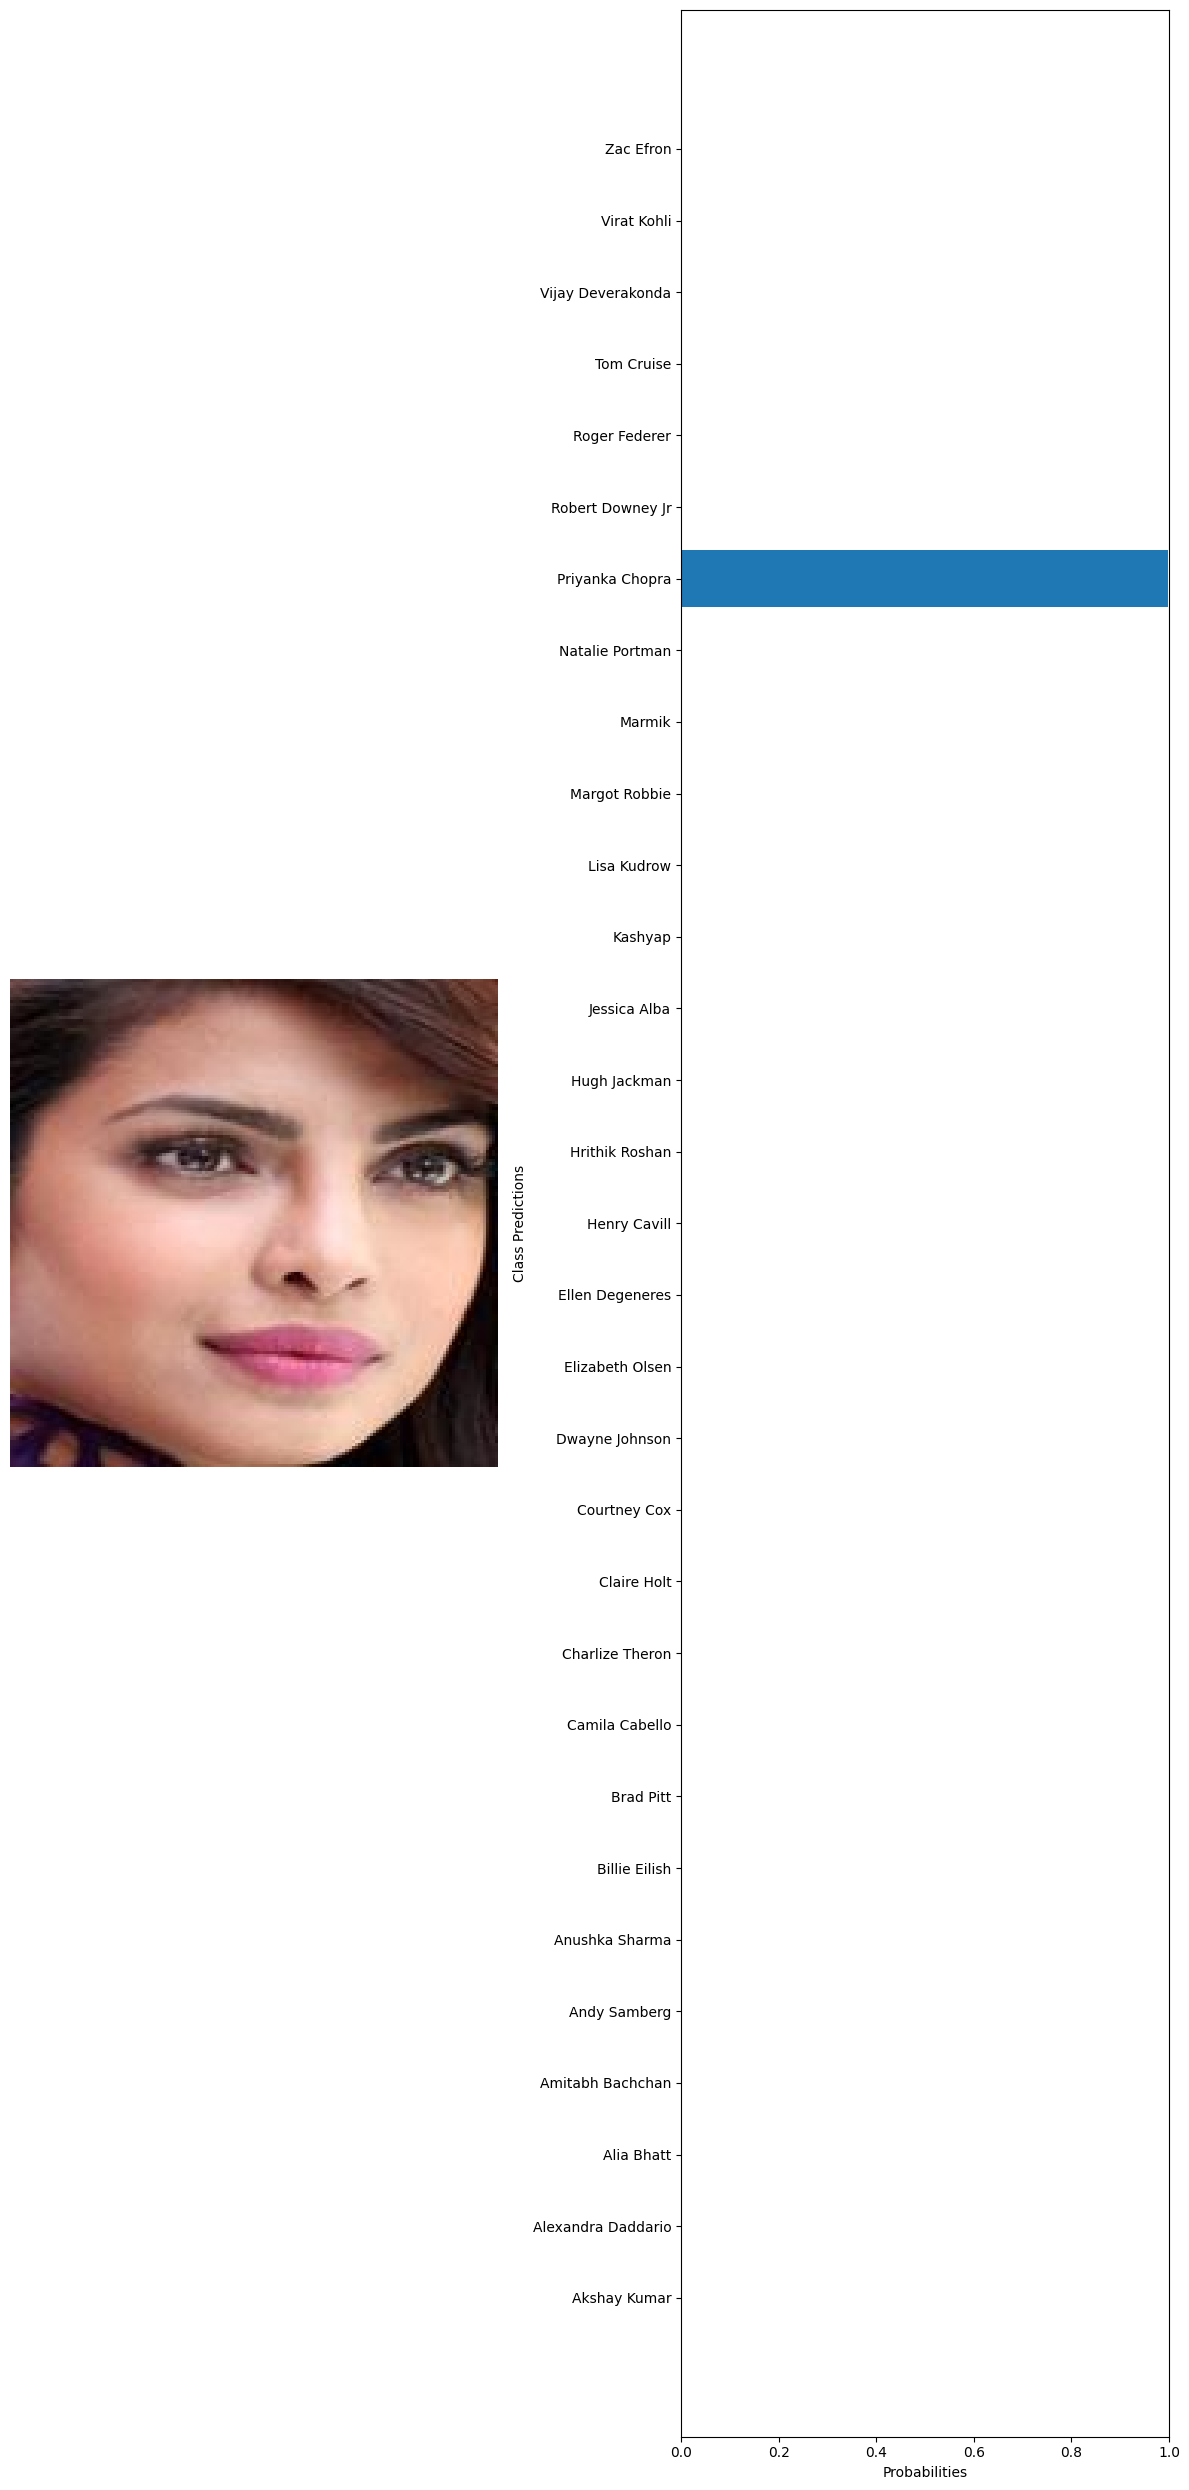

True label: Vijay Deverakonda
Predicted label: Vijay Deverakonda


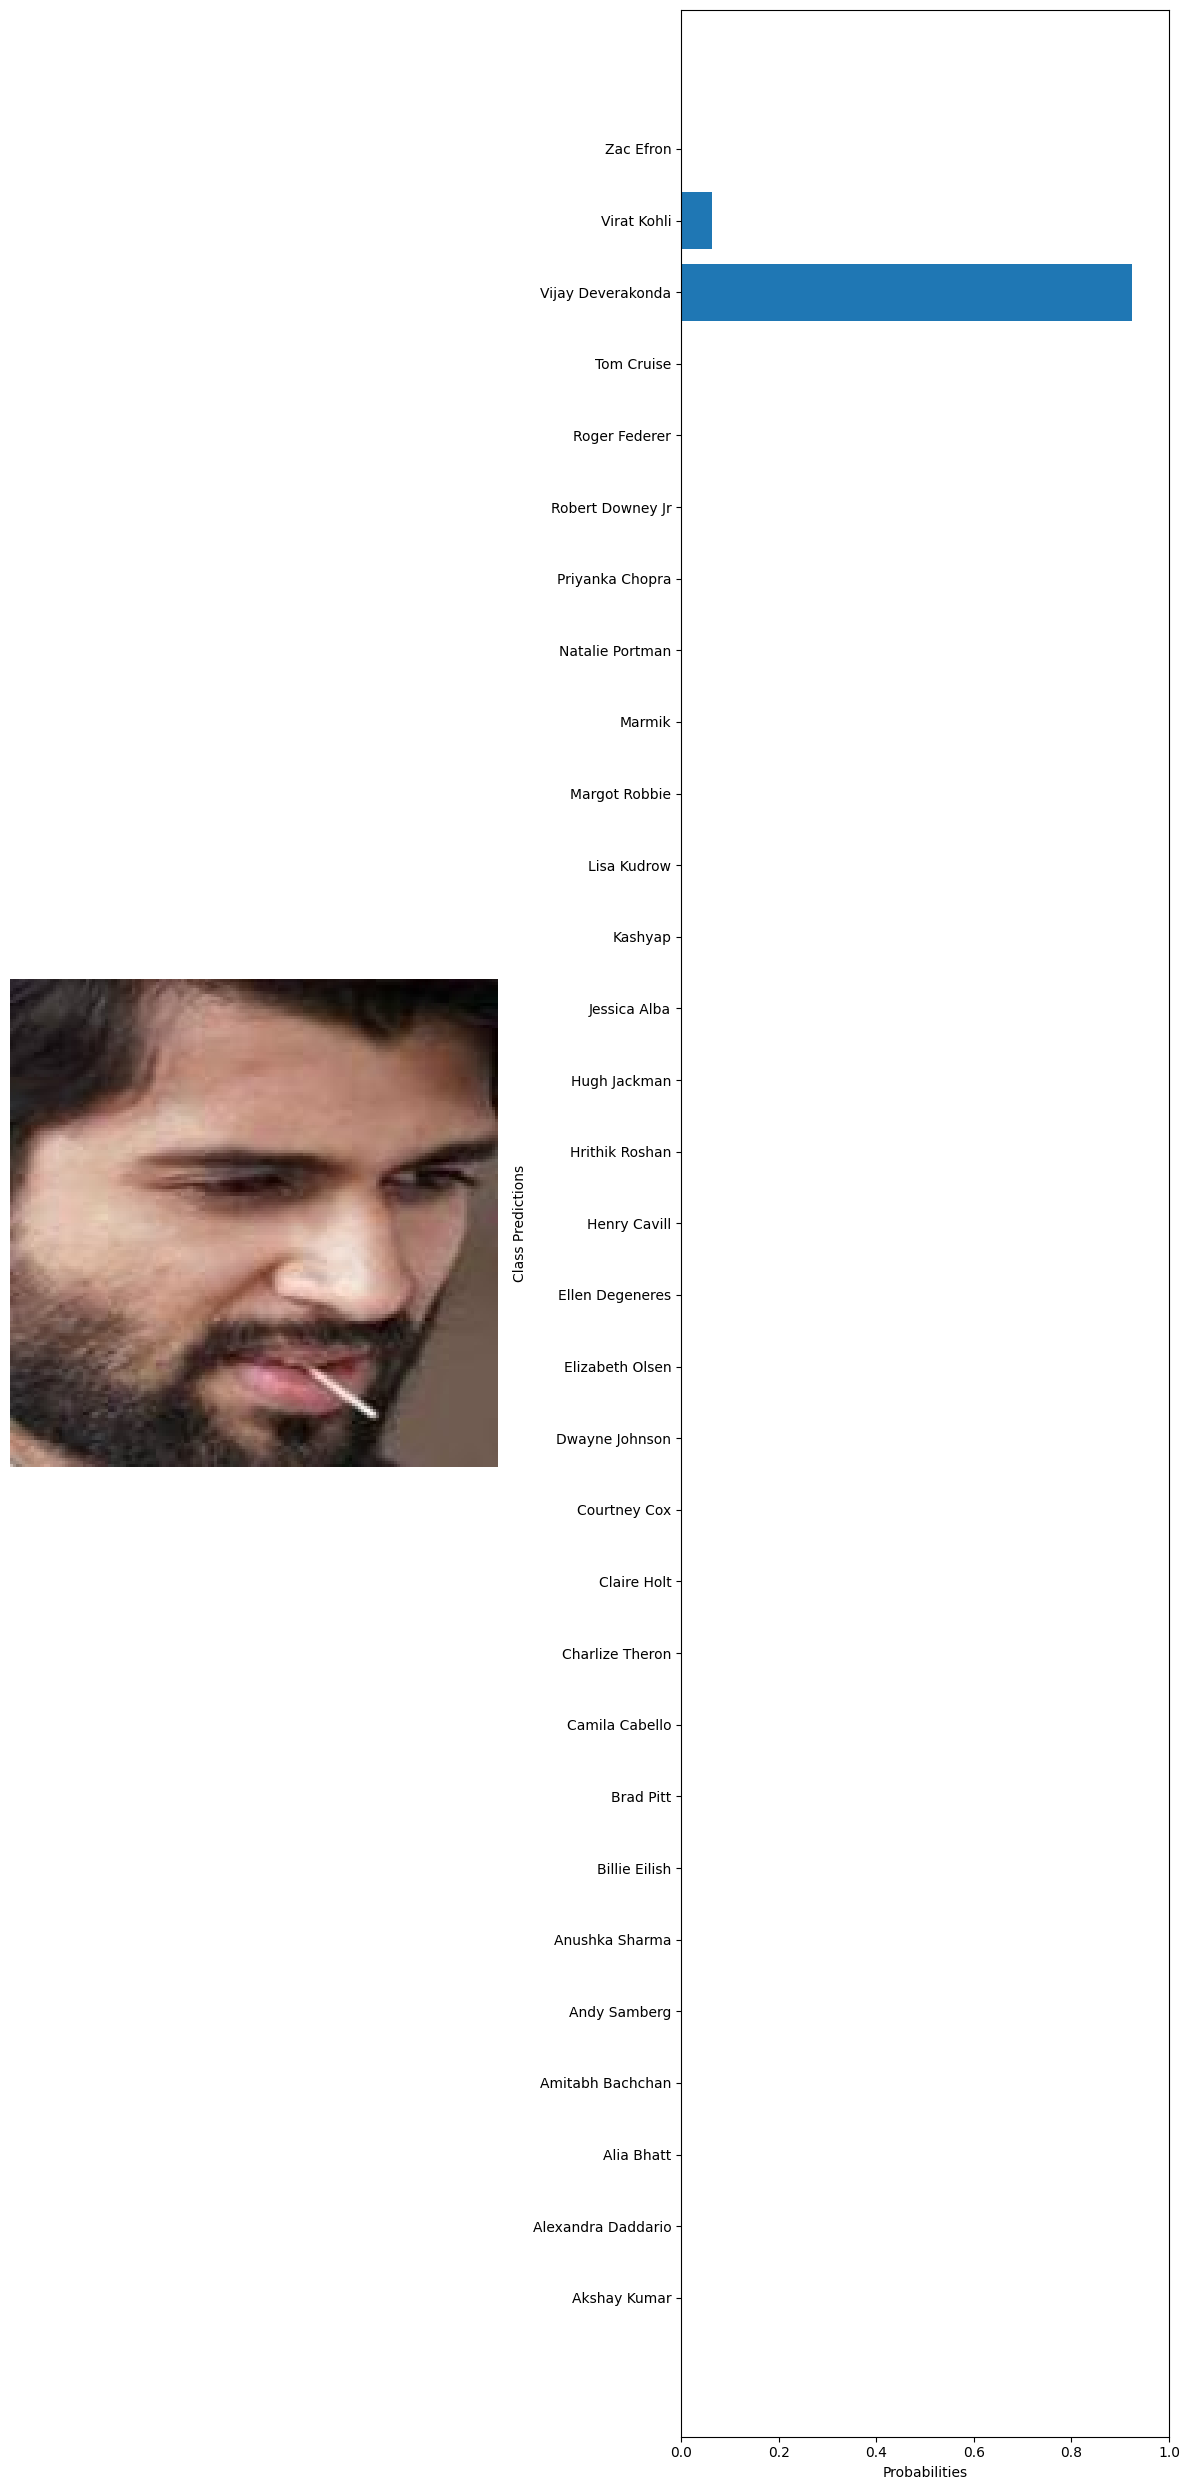

True label: Hugh Jackman
Predicted label: Hugh Jackman


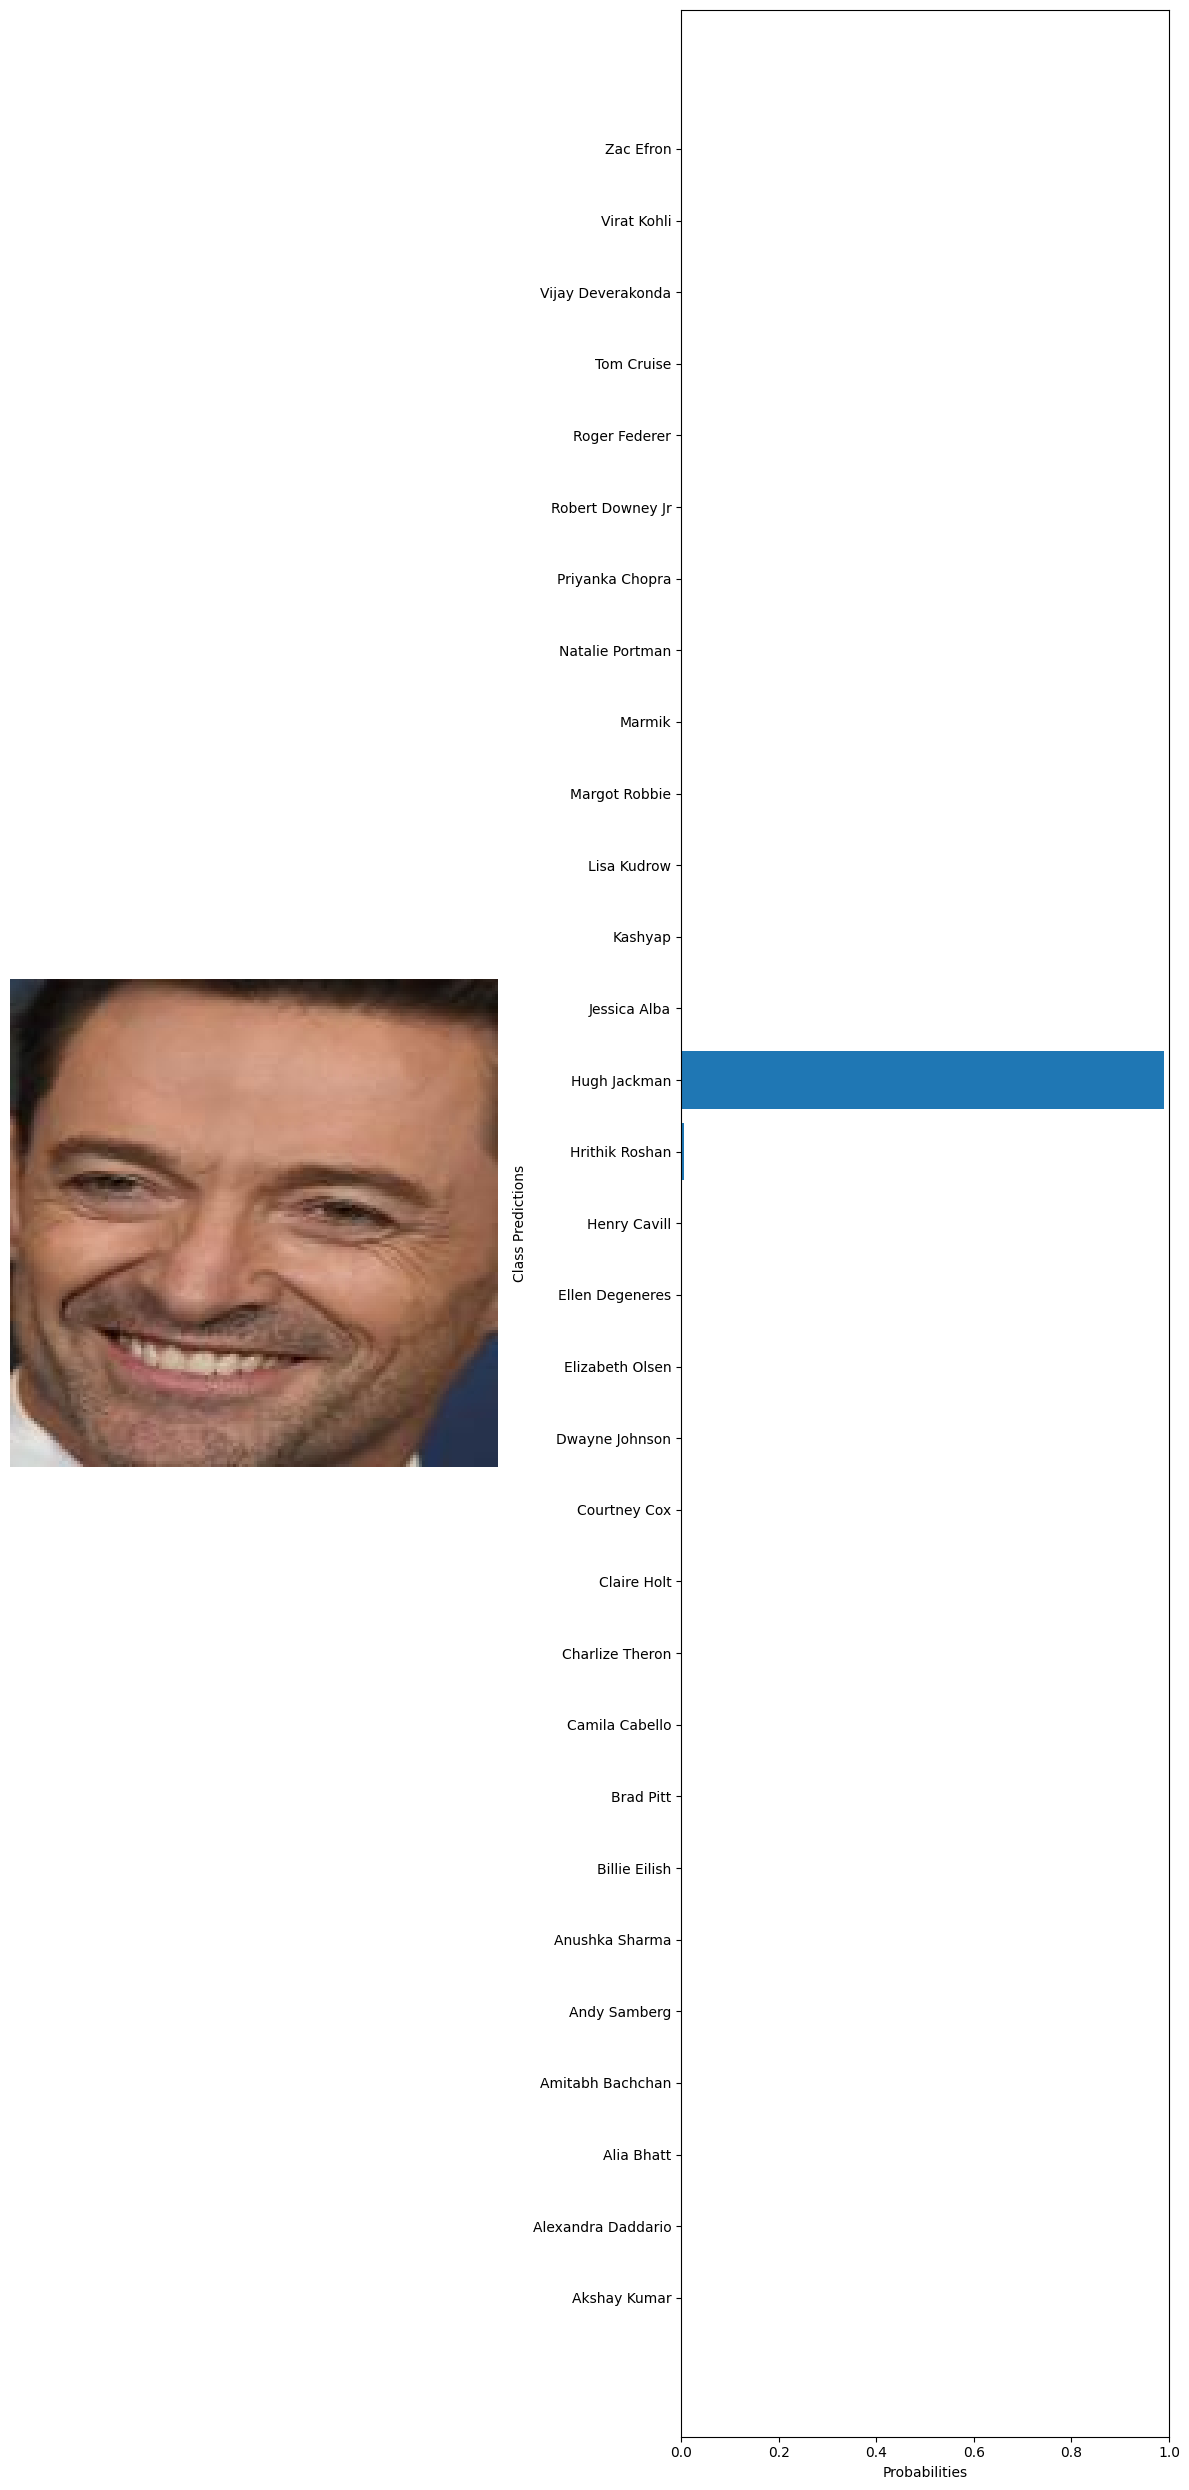

True label: Brad Pitt
Predicted label: Brad Pitt


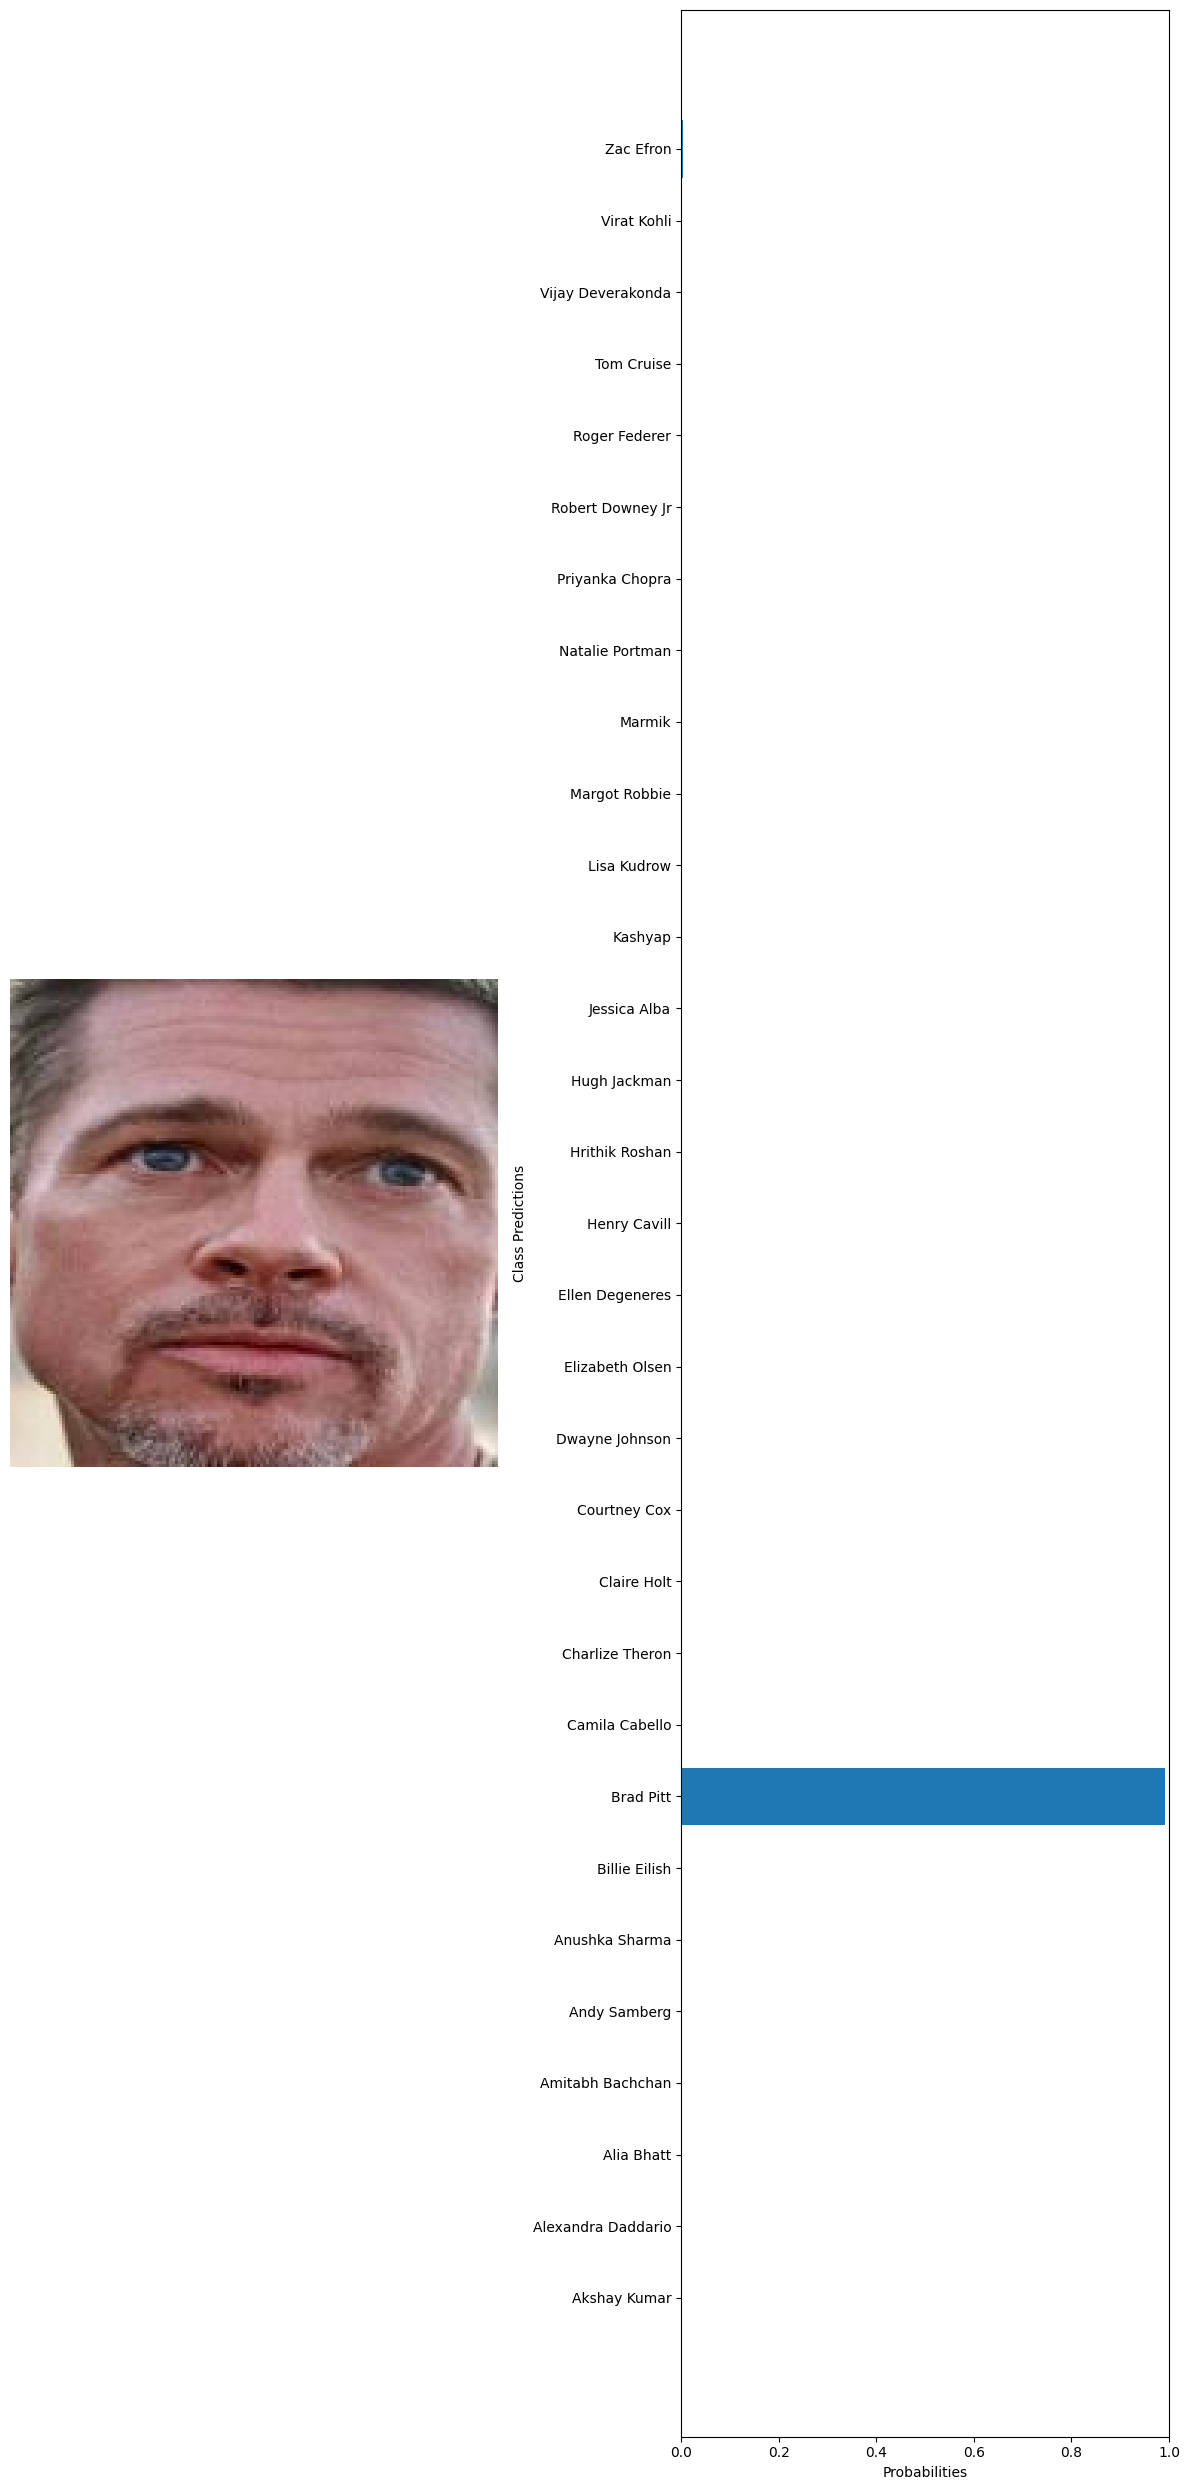

True label: Andy Samberg
Predicted label: Andy Samberg


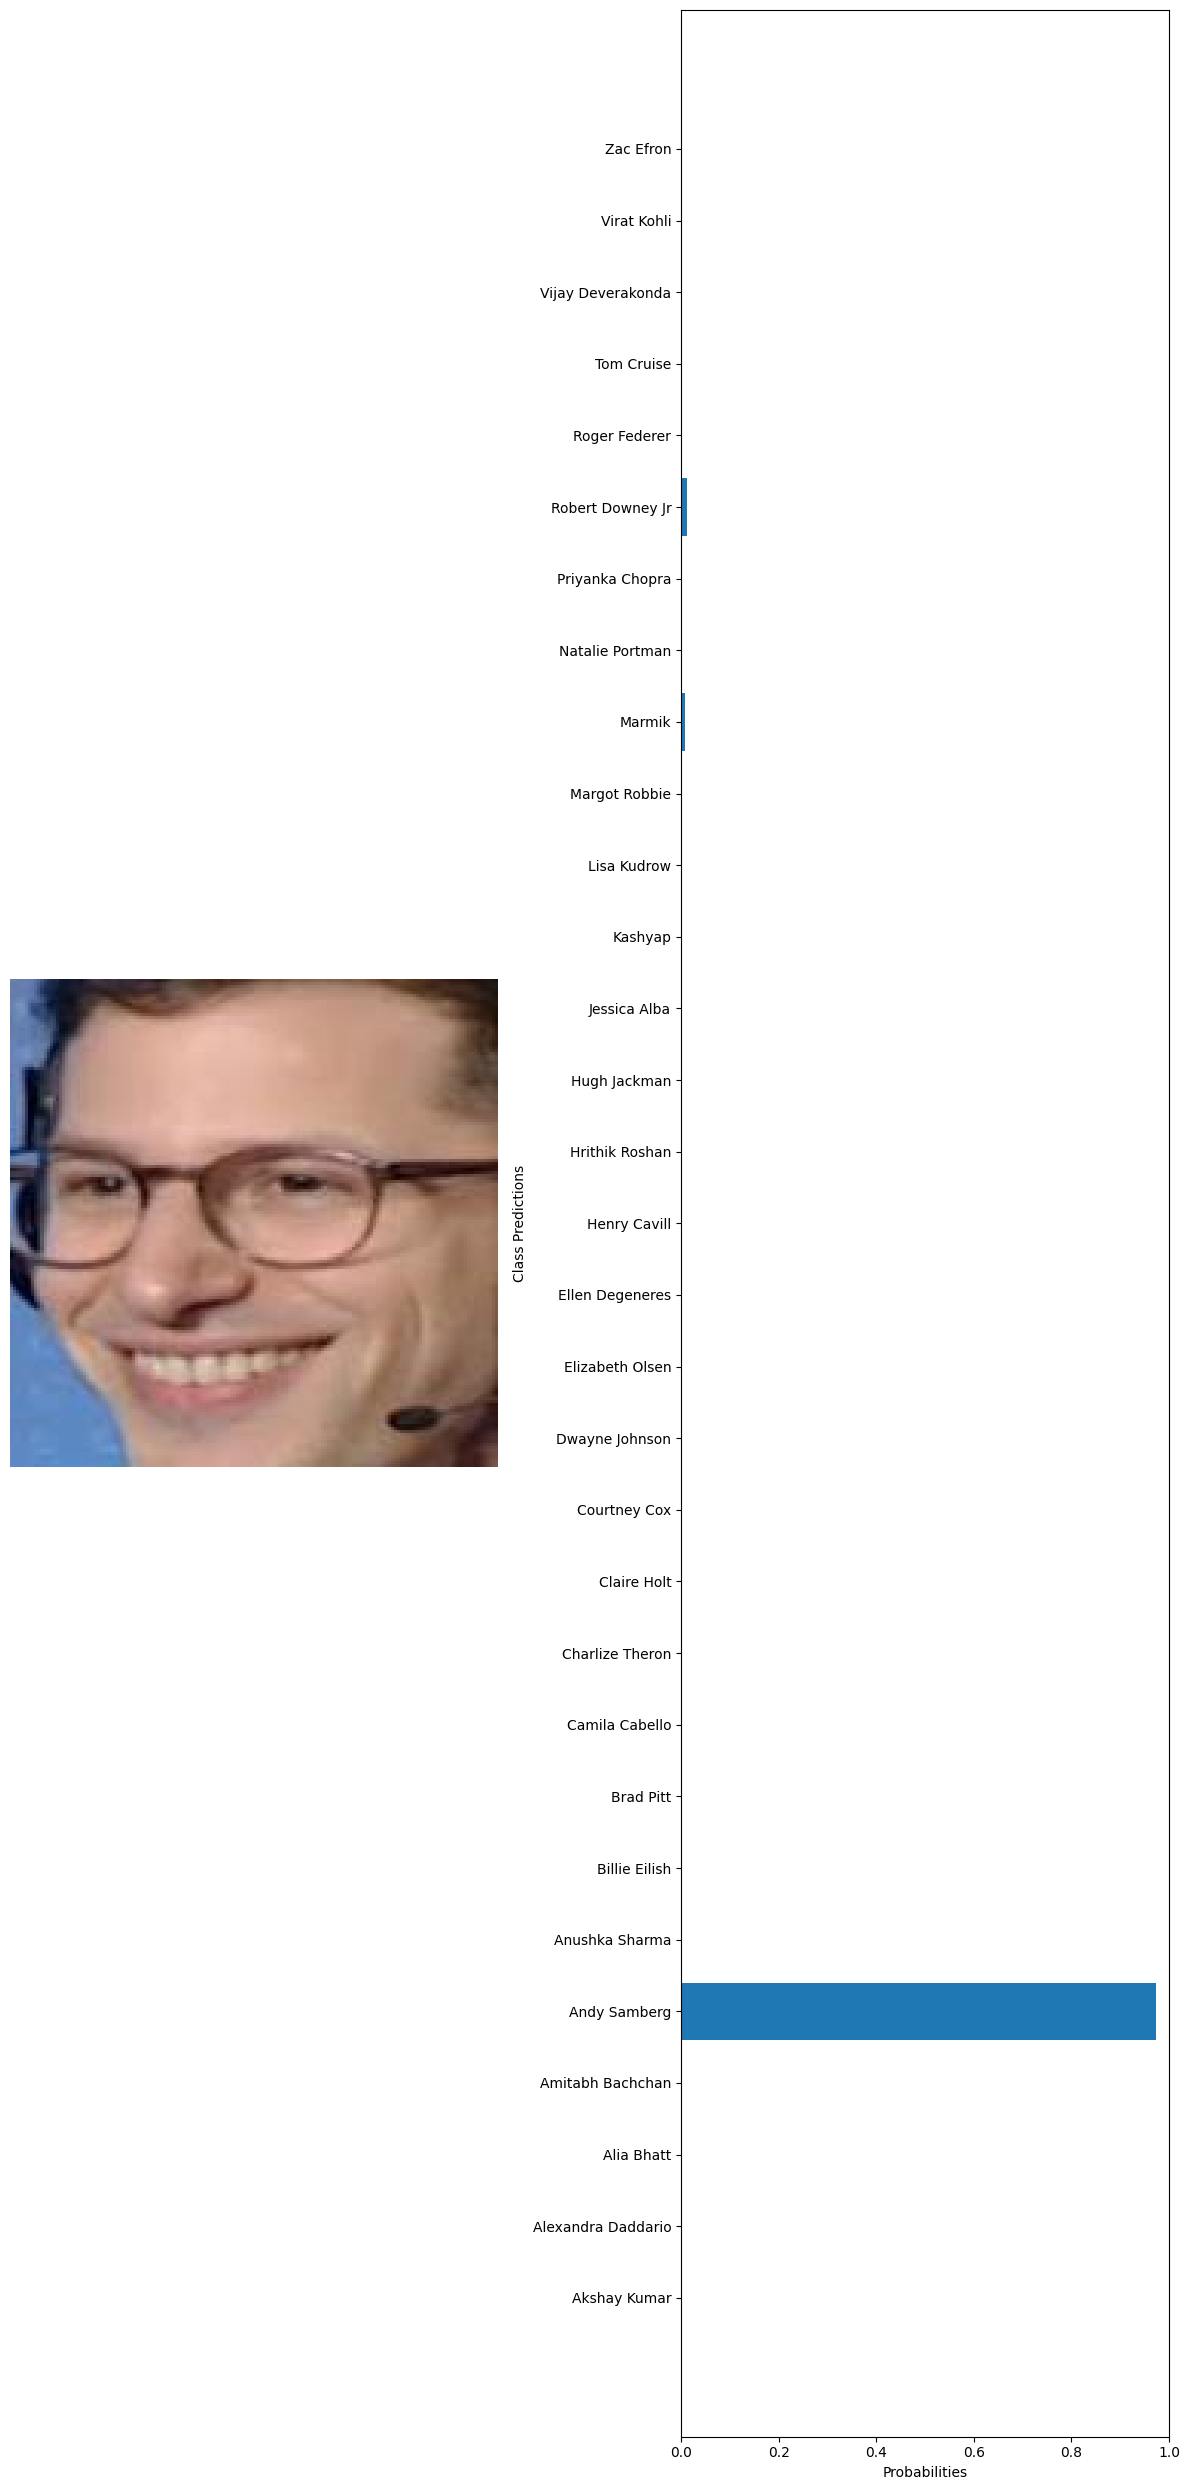

True label: Natalie Portman
Predicted label: Natalie Portman


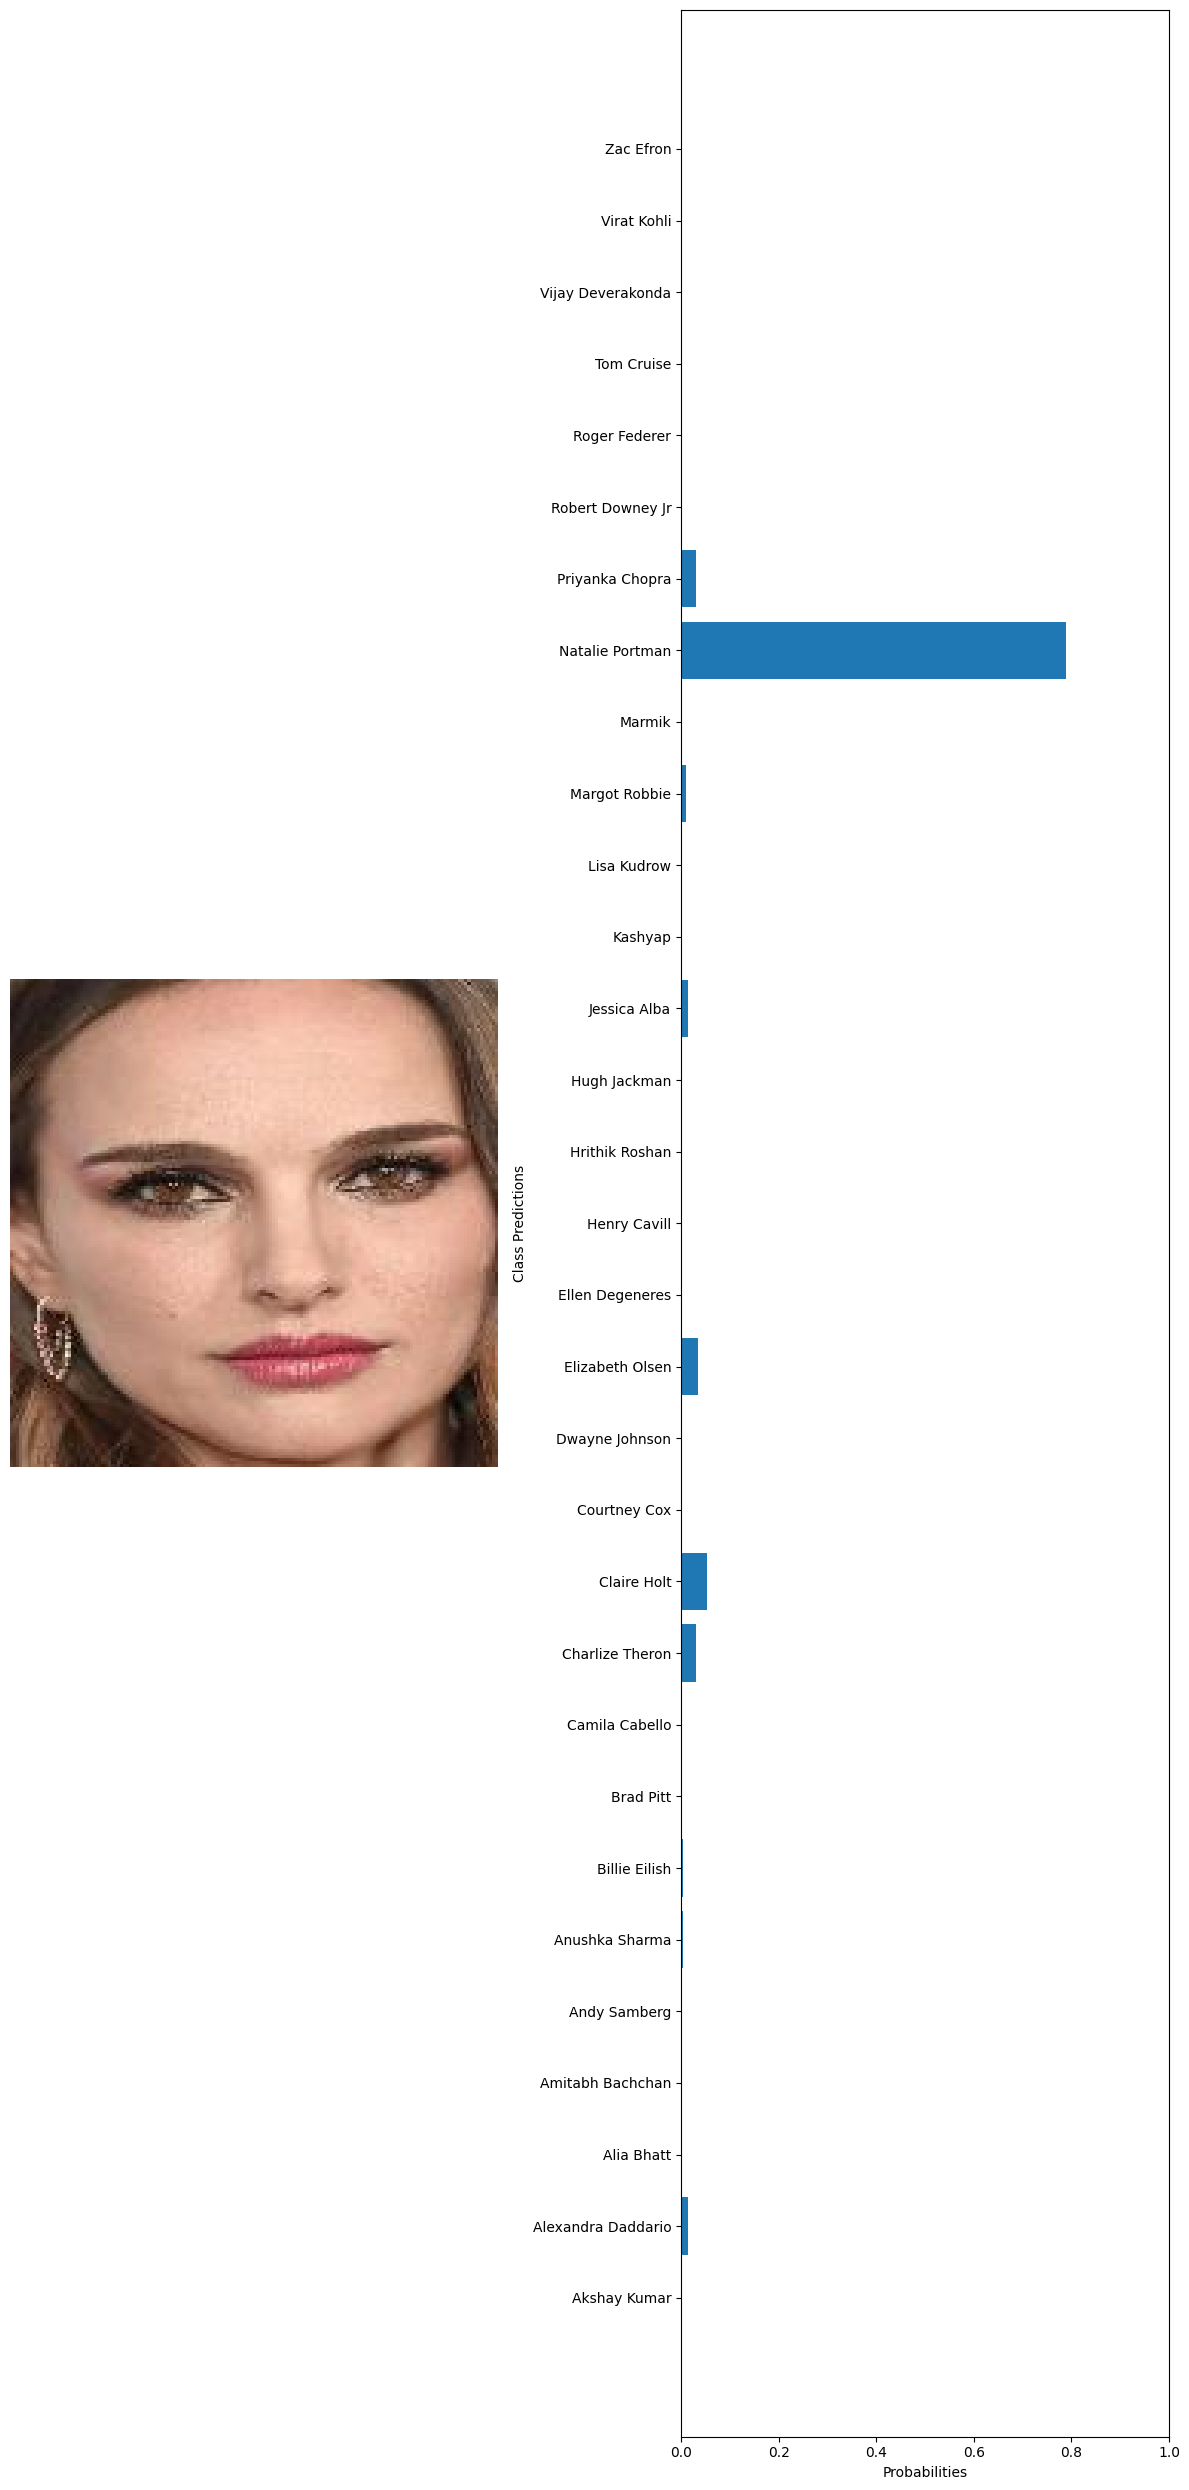

True label: Tom Cruise
Predicted label: Akshay Kumar


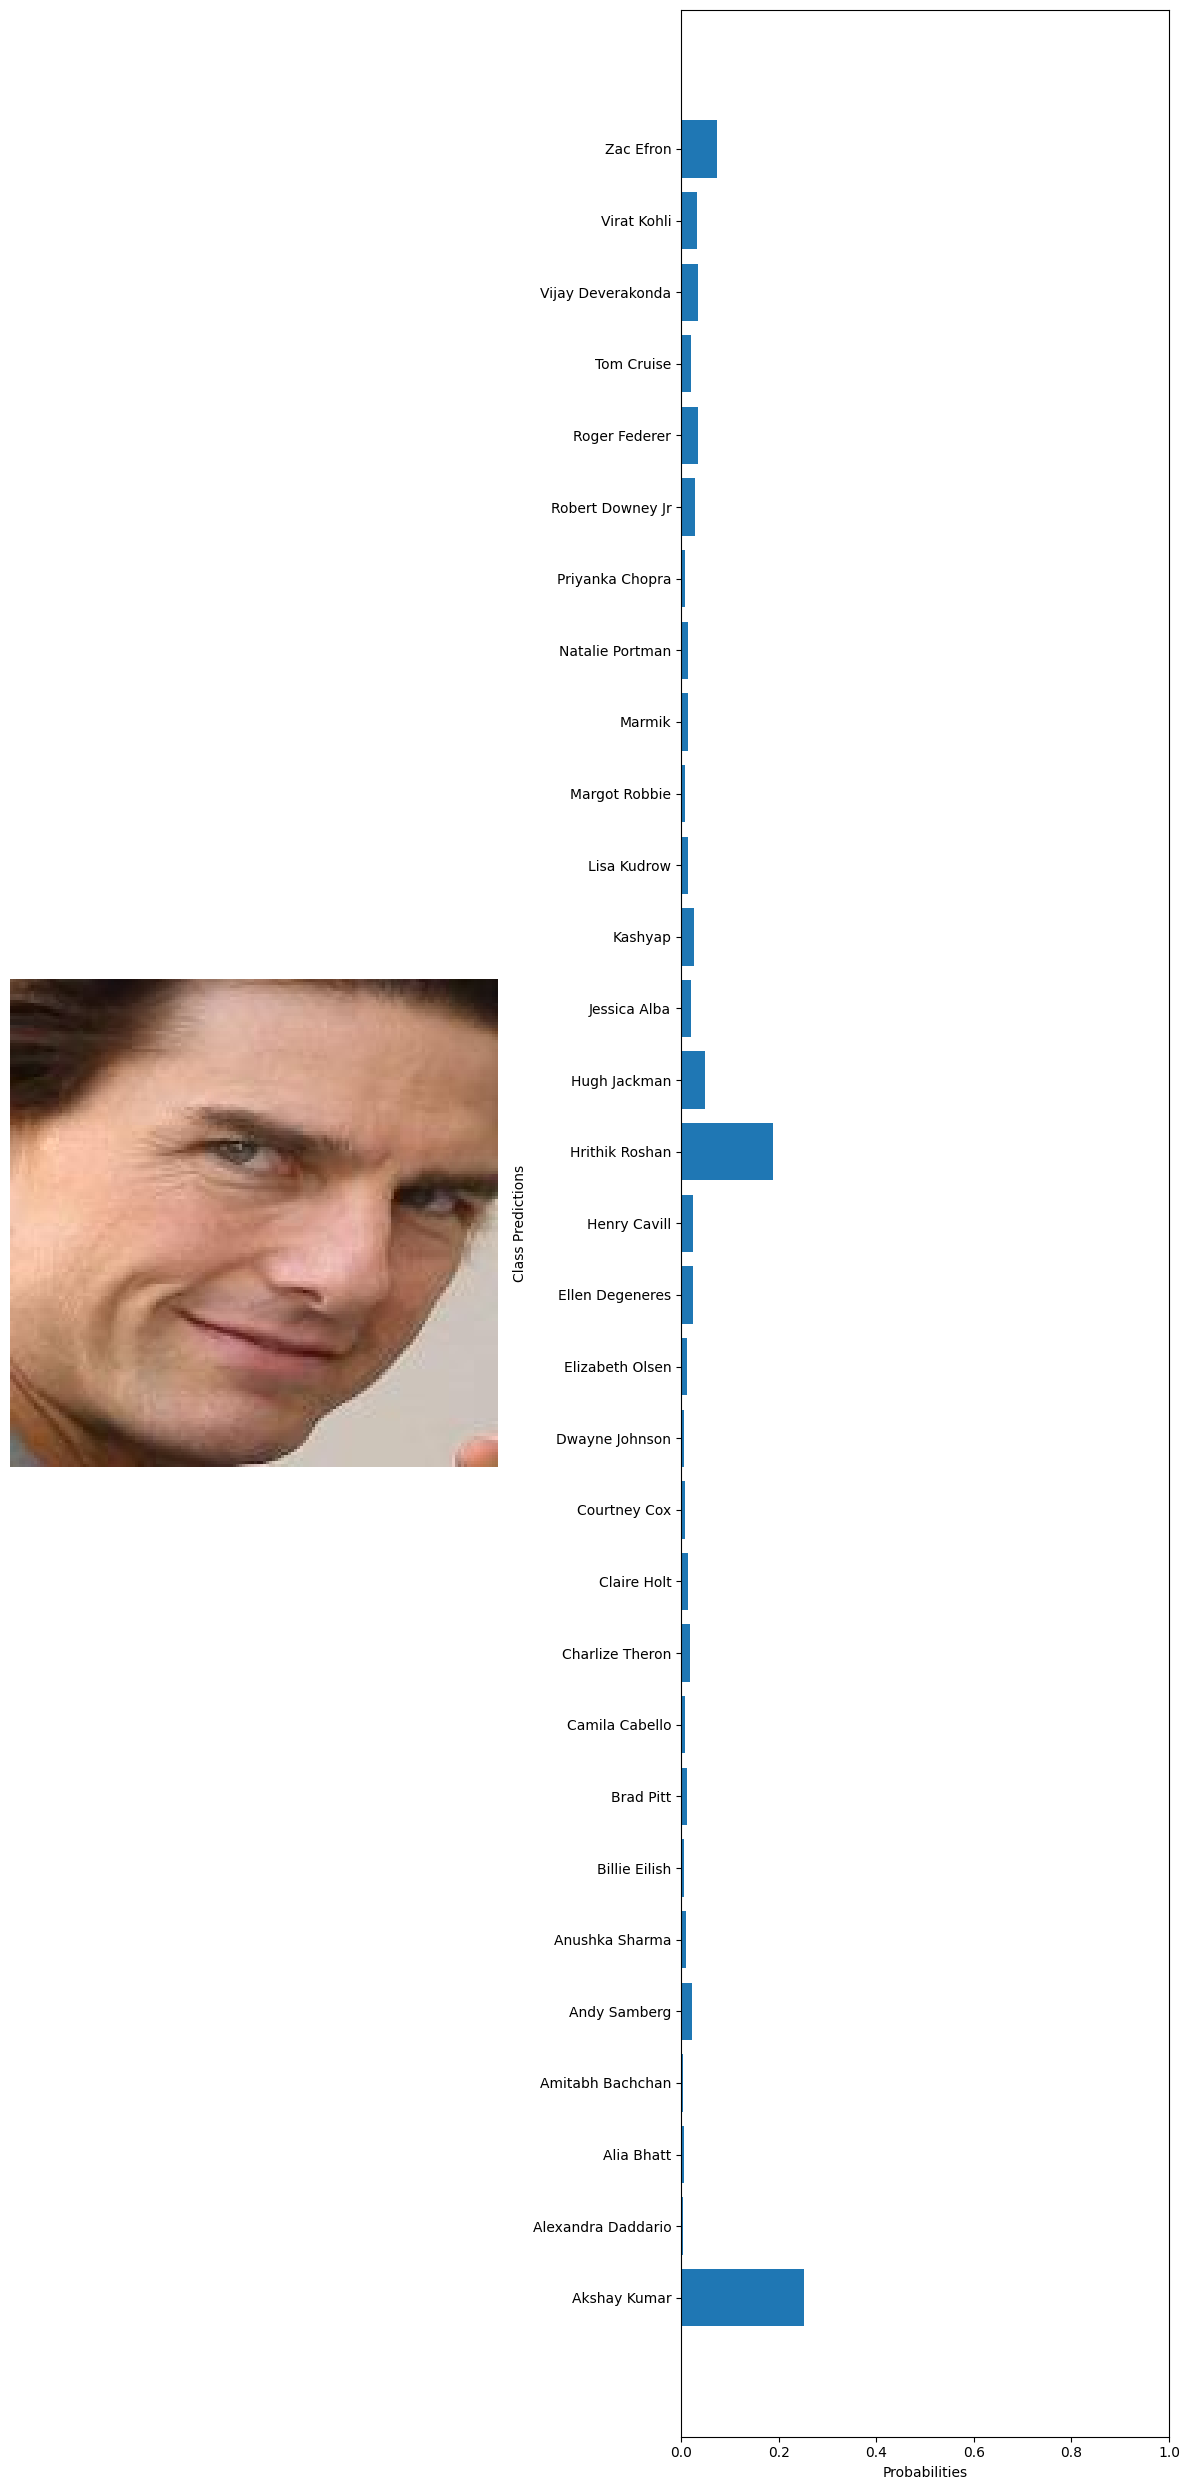

Accuracy: 0.9


In [21]:
#Calculate the accuracy of our model on the test_set
test_images=glob('../data/Face recognition/Faces/*/*')
test_examples=np.random.choice(test_images,10)
num_correct = 0
total_examples = len(test_examples)
for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming the class names from dataset.classes :
    class_names = dataset.dataset.classes
    
    # Extract ground truth label from file path
    ground_truth_label = example.split('\\')[1]  # Assuming class folder name is the label
    
    # Get predicted label
    predicted_label_index = np.argmax(probabilities)
    predicted_label = class_names[predicted_label_index]
    
    # Check if prediction is correct
    if predicted_label == ground_truth_label:
        num_correct += 1
    
    # Print ground truth and predicted labels
    print("True label:", ground_truth_label)
    print("Predicted label:", predicted_label)
    
    visualize_predictions(original_image, probabilities, class_names)
accuracy = num_correct / total_examples
print("Accuracy:", accuracy)